In [ ]:
#@markdown Загрузка библиотек
import pandas as pd
import numpy as np
import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import OrderedDict, defaultdict, Counter
%matplotlib inline

In [ ]:
#@markdown Стили для графиков
sns.set_style("whitegrid")
font = {'fontname':'Roboto'}
blue, = sns.color_palette("muted", 1)
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [ ]:
#@markdown Загрузка данных
# Все судебные акты по 20.29 с текстом решения суда
all_acts_and_text = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/acts_data_2.csv')
all_sent = all_acts_and_text.sent_text.str.lower()
all_sent_list = list(all_sent)

# Список всех экстремистских материалов (исходный датафрейм) c датами включения
extr_materials_with_dates = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/extr_materials_dates.csv', index_col='Unnamed: 0')
extr_materials_with_dates.ins_date= pd.to_datetime(extr_materials_with_dates.ins_date, format='%d.%m.%Y', errors='coerce')

# Список экстремистских материалов (отчищенные)
mats = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/final_extr_material - final_extr_material.csv', index_col=0)
mats_list = list(mats.material)
mats_list.remove('(видеозапись №8)')
mats_list = [i for i in mats_list if len(i) > 15]

# Размеченный датафрейм с приговорами
tagged_df =pd.DataFrame()
extr_mat_name = 'припомним жуликам и ворам'
sens = []
for sen in all_sent:
    if extr_mat_name in str(sen):
        sens.append(sen)

tagged_df['sentences'] = sens
tagged_df['extr_mat_name'] = [extr_mat_name for i in range(len(sens))]
tagged_sentences = list(tagged_df.sentences)

# Извелечённые из текстов приговоров названия экстремистских материалов
key_df = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/key_df - key_df.csv', index_col='Unnamed: 0')
key_df.fillna('None', inplace=True)
key_df_list = list(key_df.key_sents)

# Датафрейм с названием материала из приговора и предсказанным экстр. материалом из реестра
pred_mat_df = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/brut_search_pd.csv', index_col='Unnamed: 0')

# Итоговый датафрейм с названием материала из приговора, предсказанным экстр. материалом из реестра и данными из приговора
# pred_mat_df_full = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/pred_mat_df_full.csv', index_col='Unnamed: 0')
pred_mat_df_full = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/last_df.csv', index_col='Unnamed: 0')

mat_df_with_categories = pd.read_csv('/content/drive/MyDrive/Экстремистские материалы/extr materials with category.csv', index_col='Unnamed: 0')

## Что такое реестр экстремистских материалов?
Федеральный список экстремистских материалов составляется Минюстом. В него включаются различные материалы, признанные судом экстремистскими. В законе понятие экстремистские материалы определены следующим образом:

"призывающие к осуществлению экстремистской деятельности либо обосновывающие или оправдывающие необходимость осуществления такой деятельности, в том числе труды руководителей национал-социалистской рабочей партии Германии, фашистской партии Италии, публикации, обосновывающие или оправдывающие национальное и (или) расовое превосходство либо оправдывающие практику совершения военных или иных преступлений, направленных на полное или частичное уничтожение какой-либо этнической, социальной, расовой, национальной или религиозной группы".

Впервые этот список был опубликован 14 июля 2007 года и сначала состоял всего из 14 пунктов. Среди них был, например, музыкальный альбом омской рок-группы Order "Музыка белых" и снятый в 1940 году в Германии фильм "Вечный жид". С тех пор список регулярно обновляется. В него добавляли всё новые статьи, листовки и брошюры, книги, номера газет и журналов, кинофильмы, видеоролики, музыкальные произведения и произведения изобразительного искусства. Материалы самого разного характера: националистические, оппозиционные (ролик Алексея Навального "Припомним жуликам и ворам их обещания") и религиозные (свидетелей Иеговы, церкви Саентологии). Исключениями являются являются Библия, Коран, Танах и Ганджур, их содержание и цитаты из них.

Всё это в итоге привело к тому, что на сегодняшний день в реестре уже более 5 тысяч различных материалов. Многие описания этих материалов непонятные, могут содержать одно лишь название или длинные ссылки. Это  делает идентификацию материалов затруднительной, а вероятность привлечения к ответственности за публикацию того или иного материала труднопредсказуемой, считают эксперты  информационно-аналитического центра "Сова".

*Комментарий эксперта о том, почему этих материалов так много*

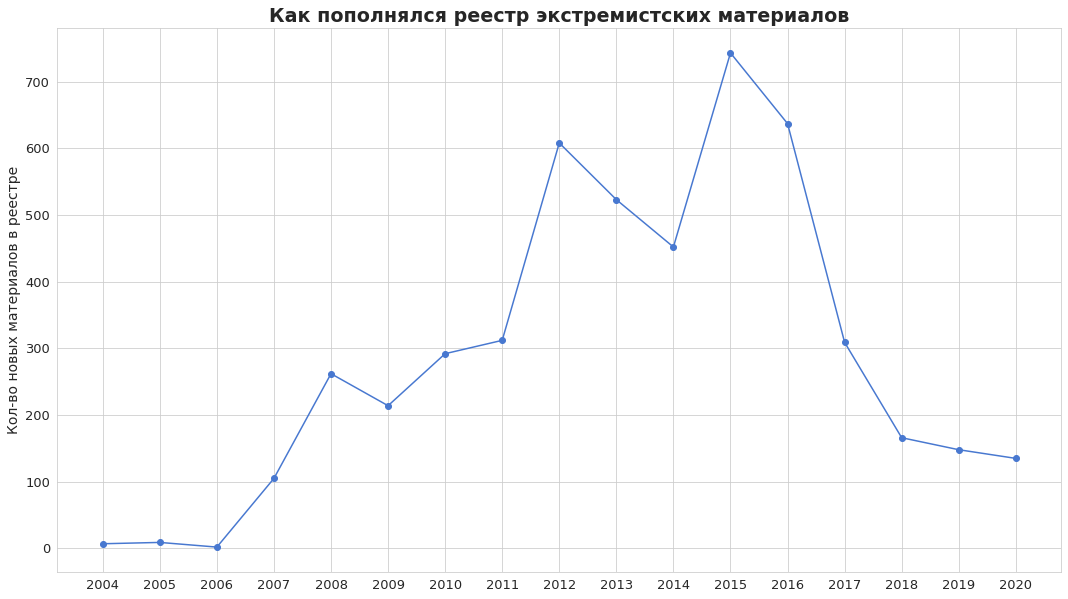

In [ ]:
#@title
extr_dates = extr_materials_with_dates.groupby(extr_materials_with_dates.ins_date.dt.year)[['default_materials']].count()
extr_dates.index = extr_dates.index.astype(int)

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(extr_dates, color=blue, marker='o')
ax.set_title('Как пополнялся реестр экстремистских материалов', size=19, **font).set_weight('semibold')
ax.set_xticks(np.arange(min(extr_dates.index), max(extr_dates.index)+1))
ax.set_ylabel('Кол-во новых материалов в реестре')
# добавление цифр на график
#for x, y in zip(extr_dates.index, extr_dates.default_materials):
#    plt.text(x, y, str(y), color="black", fontsize=14)

plt.show()

### Как материалы становятся экстремистскими?

Материалы становятся экстремисткими по решению суда. Соответсвующий иск подаёт прокурор на основании экспертизы в рамках проверочных и следственных мероприятий, которые проводят правоохранительные органы или сама прокуратура.

*Комментарий эксперта о том, как проходит экспертиза*

До октября 2019 года такие иски были аналогичны гражданским и могли проводиться в отсутствие заинтересованных лиц. С октября 2019 года запущена новая административная процедура запрета материалов как экстремистских (по Кодексу административного судопроизводства РФ), предусматривающая:
― обязательное участие в процессе создателя или публикатора материала либо омбудсмена РФ или субъекта федерации;
― возложение на создателя или публикатора судебных расходов;
― возможность превентивной судебной блокировки материала в интернете;
― немедленное вступление решения в силу.

*Комментарий эксперта о том, как по факту проходят такие судебные заседания*

In [ ]:
#@markdown Примеры материалов из реестра
for i in extr_materials_with_dates.default_materials.sample(5).values:
    print(i, '\n')

Информационный материал - текстовый документ под наименованием «Противникам Кавказского Имарата», обнаруженный и изъятый в ходе мониторинга МИС Интернет на сайте «www.jamaattkbr.com» (решение Нальчикского городского суда Кабардино-Балкарской Республики от 16.09.2011); 

Текстовый документ «109 Приговор», папка «Указы1» CD-R диск № 1 (решение Ахтубинского городского суда Астраханской области от 07.05.2009). 

Статья «Razyasnenie otnositelno kritiki I somnenij», опубликованная в международной компьютерной сети «Интернет» на информационном сайте «fisadilillahi.com» (решение Советского районного суда г. Махачкалы Республики Дагестан от 15.03.2011). 

№ 16 журнала Великоросской национальной партии «Великоросский хозяин» 2006 «Почему всем великороссам надо быть националистами?» (заочное решение Бутырского районного суда города Москвы от 07.10.2009). 

Видеозапись «Путин публично, на собрании евреев признался в том, что он еврей», продолжительностью 02 минуты 15 секунд (решение Сыктывкарского

## Зачем нужно антиэкстремистское законодательство
За распространение этих материалов возможна либо административная ответственность (в основном статья 20.29 или 20.3 КоАП), либо уголовная (статьи 280, 282 УК). Причем распространение одного и того же материала может квалифицироваться как возбуждение ненависти либо призывы к экстремистской деятельности и, соответственно, преследоваться в  уголовном  порядке,  если  следствие  усмотрит соответствующий  мотив  у  обвиняемого. Понятного всем формального признака, разграничивающего административную и уголовную квалификации, не существует. В итоге годы существования этого реестра вынесены сотни приговоров по уголовным и административным статьям. 

Закон «О противодействии экстремистской деятельности» был принят в 2002 году. В первые годы правоприменение этого закона было направлено на борьбу с неонацистскими группировками, практиковавших ксенофобное насилие. В начале 2000-х эта работа была недостаточно систематизированной и эффективной. Но уже с 2008 года, когда в системе МВД России заработали центры по противодействию экстремизму (центры "Э"), власти стали уделять этой теме гораздо больше внимания.

И кажется, что эта тактика сработало. Эксперты отмечают, что в 2010 году был пик таких преступлений, после чего их число только сокращалось. Эксперты "Совы" считают, что в какой-то мере введение и применение антиэкстремистского законодательства успешно подавило волну ксенофобного насилия в России.

&#9744; *Обработать данные Совы по насилию (есть на [сайте](https://www.sova-center.ru/database/violence/?tip1=301&xfield=phenotype&yfield=y&victims=Min&show=1))*

Однако с начала 2010-х годов начало расти число дел против сторонников запрещенных религиозных течений, не занимающихся политической деятельностью и не призывающих к насилию, таких, как последователи мусульманского богослова Саида Нурси (их причислили к единой организации – объединению «Нурджулар», которое и было признано экстремистским), «Таблиги Джамаат» и некоторые другие.

Последний виток преследований за продолжение деятельности экстремистских организаций связан с запретом всех местных организаций Свидетелей Иеговы в России, который произошел в 2017 году (ранее запрещались только отдельные общины и преследовались по разным антиэкстремистским статьям отдельные верующие). Все материалы этих организаций через некоторое время оказываются в реестре Минюста. 

&#9744; *Найти на данных подтверждение этих тезисов*

В 2010-е изменилась не только "целевая аудитория" против кого было направлено антиэкстремистское законодательство. Борьба с экстремизмом также ушла в онлайн. Выявление преступлений в сети – дело не затруднительное и позволяющее легко формировать позитивную статистику борьбы с экстремизмом. При этом среди силовиков было распространено мнение, что, поскольку наказания, связанные с лишением свободы, по антиэкстремистским статьям назначаются редко, судимость по ним можно считать профилактической мерой. Результатом стал быстрый рост числа осужденных за «экстремистские» высказывания в интернете – преимущественно, по статье 282 УК.

## Как статью 20.29 КоАП применяют в России

Но гораздо быстрее высросло число привлекаемых к административной ответсвенности. Основная административная статья, по которой привлекали за распространение экстремистских материалов - 20.29 КоАП. Эта статья касается  массового  распространения  экстремистских  материалов  и  их  хранения  с  целью  массового  распространения.

Росту приговоров по 20.29 способствовало стремительное разрастание Федерального списка экстремистских материалов.

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


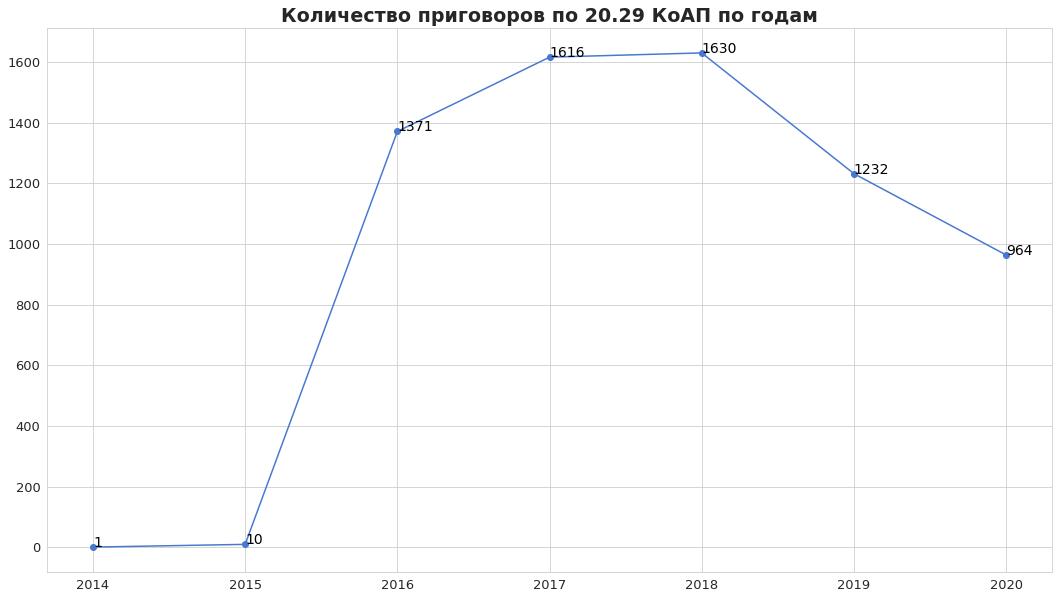

In [ ]:
#@title
group_by_year = pred_mat_df_full.groupby(['year'])[['sent_text']].count().reset_index()

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(group_by_year.year, group_by_year.sent_text, color=blue, marker='o')
ax.set_title('Количество приговоров по 20.29 КоАП по годам', size=19, **font).set_weight('semibold')
for x, y in zip(group_by_year.year, group_by_year.sent_text):
    plt.text(x, y, str(y), color="black", fontsize=14, **font)
plt.show()


Число привлеченных к ответственности по статьям 20.3 и 20.29 КоАП граждан и организаций в 2017 и 2018 годах составляло более 3500 ежегодно, в то время как в начале десятилетия таковых были лишь десятки каждый год. Значительная доля массива правоприменения приходится на наказания малоизвестных пользователей соцсетей, не всегда придерживающихся радикальных убеждений. Нередко наказывают распространителей материалов, попавших в Федеральный список без достаточных оснований, а также тех, кто использовал нацистскую символику вовсе не для пропаганды нацизма. Обе статьи также оказались удобным инструментом давления на мирную оппозицию.

&#9744; *Собрать данные по 20.3 КоАП*


Причем эти приговоры достаточно неравномерно разошлись по регионам. В России образовалось 20 регионов-рекордсменов по экстремизму, в которых вынесено порядка 60% приговоров по статье 20.29 КоАП.

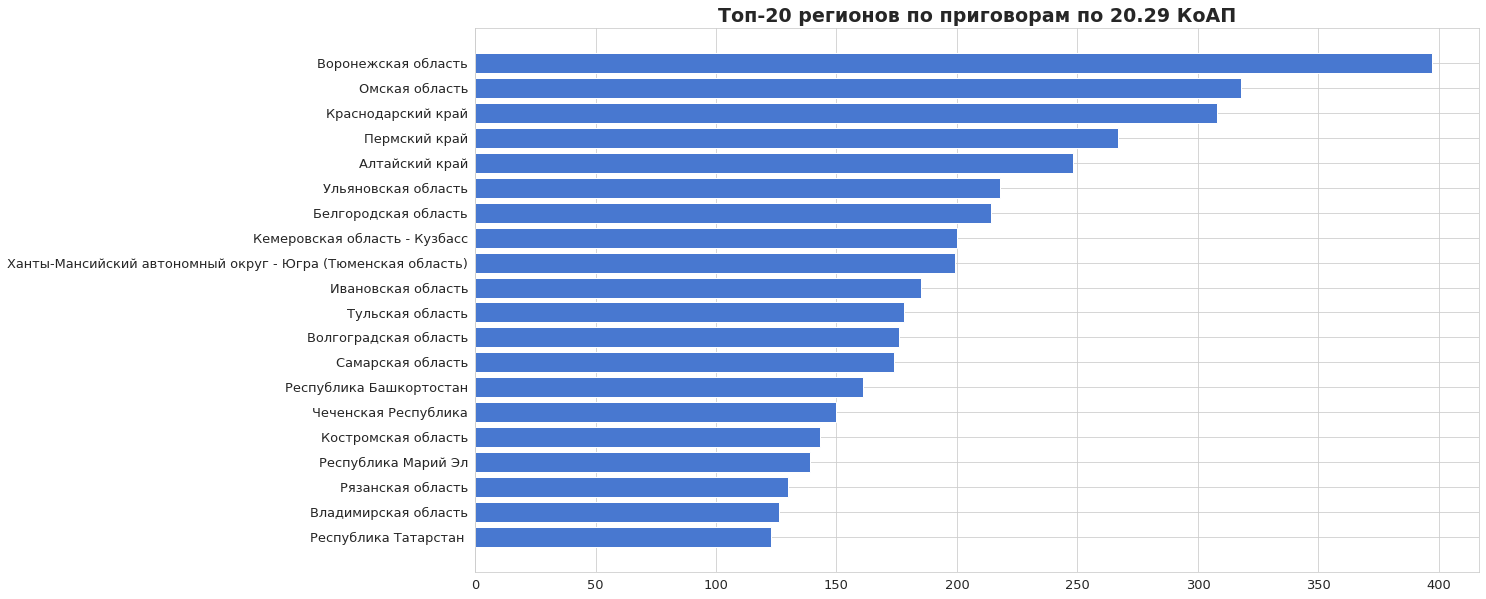

In [ ]:
#@title

group_by_region = pred_mat_df_full.groupby('region')['sent_text'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18,10))
ax.barh(group_by_region.head(20).index, group_by_region.head(20), color=blue)
ax.set_title('Топ-20 регионов по приговорам по 20.29 КоАП', size=19, **font).set_weight('semibold')
ax.invert_yaxis()
plt.show()

Вместе с этим есть регионы, где за всё время не набралось и десяти приговоров за массовое распространение экстремистских материалов.

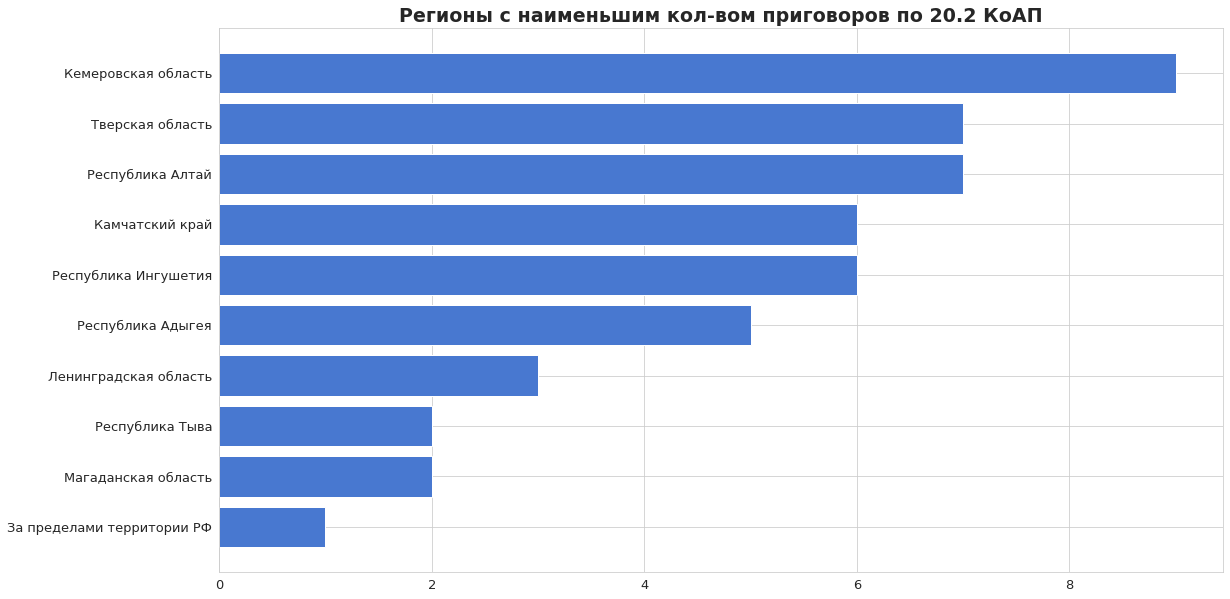

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(18,10))
ax.barh(group_by_region.tail(10).index, group_by_region.tail(10)['Кол-во приговоров'], color=blue)
ax.set_title('Регионы с наименьшим кол-вом приговоров по 20.2 КоАП', size=19, **font).set_weight('semibold')
ax.invert_yaxis()
plt.show()

Также можно проследить как эта динамика по годам развивалась в регионах

* В 2015-2016 гг. лидером по приговорам был Пермский край
* В 2017-2018 гг. статью начали активно осваивать в Краснодарском крае и Воронежской области, последняя в целом является лидером по приговорам на 20.29
* В 2019-2020 гг. в последние два года активнее всего экстремистские материалы распространяли в в Алтайском крае 

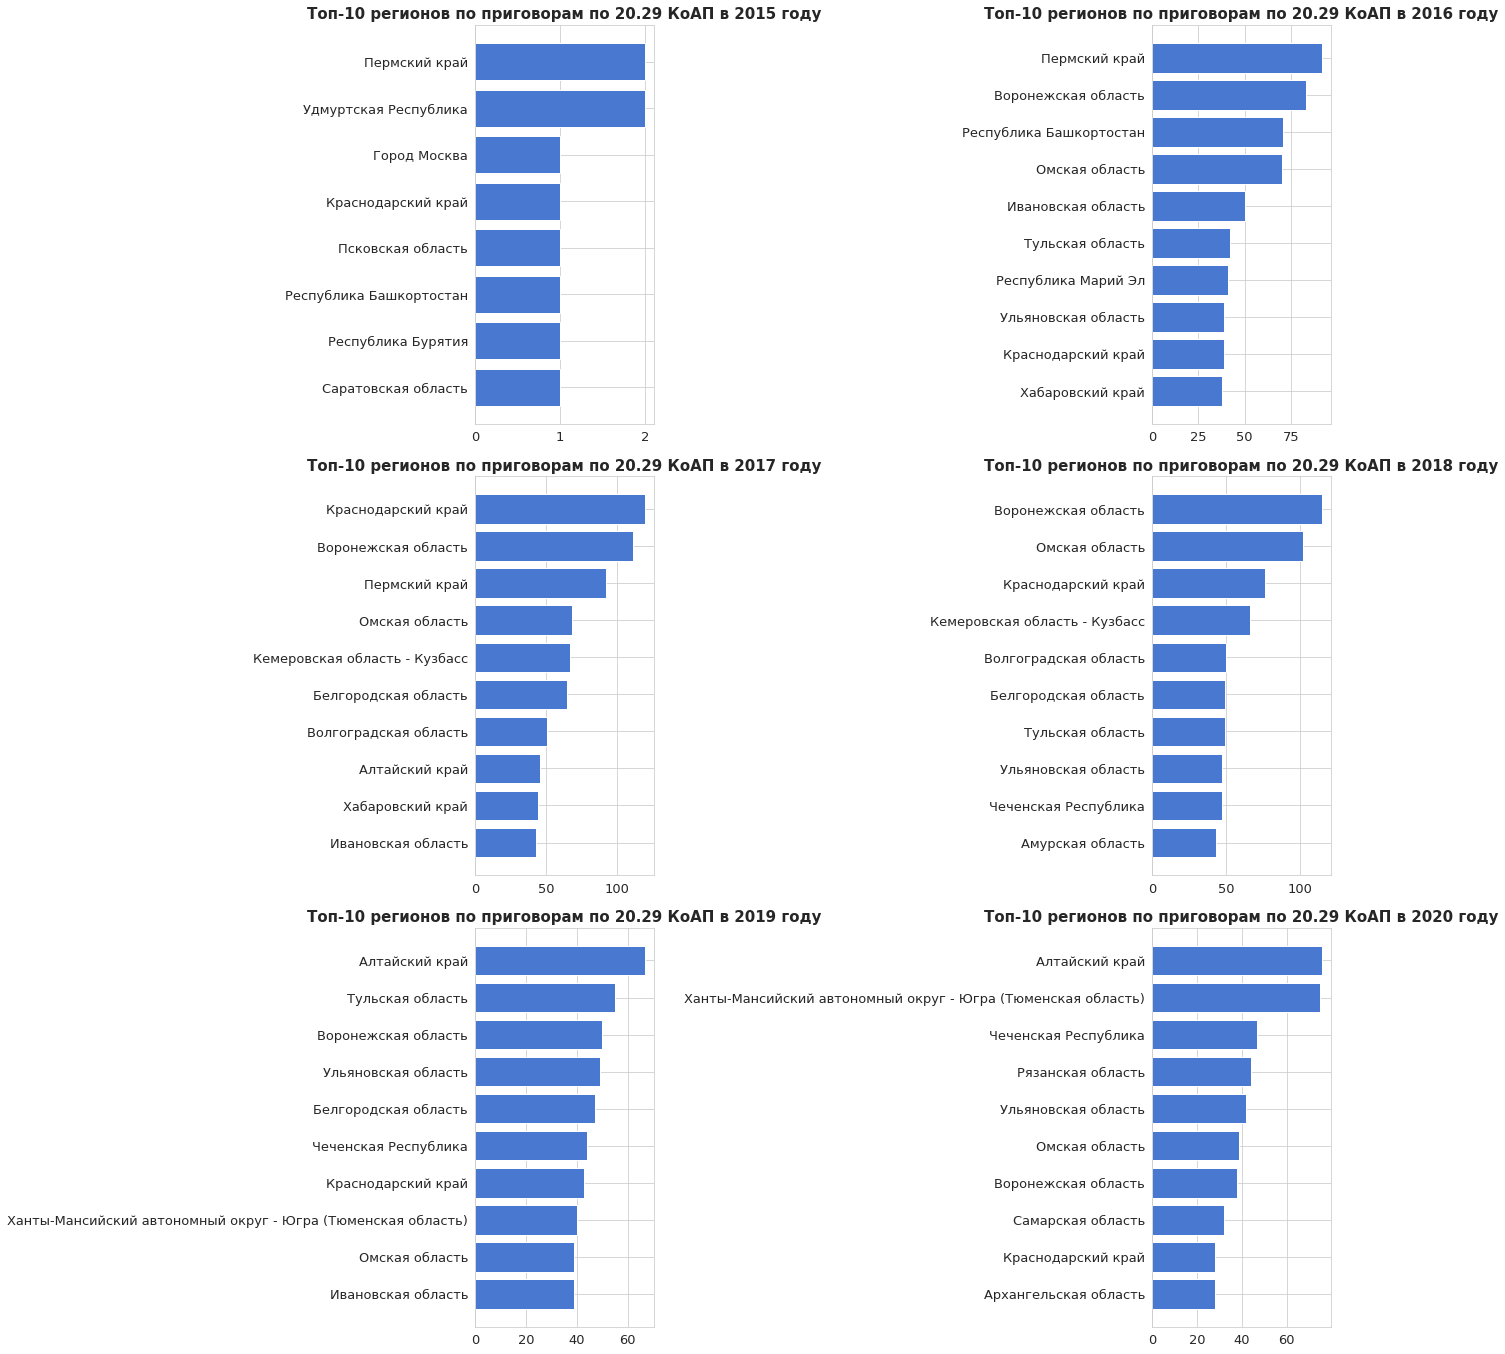

In [ ]:
#@title
s = pred_mat_df_full.groupby(['year', 'region'])[['sent_text']].count()
years = list(pred_mat_df_full.year.unique())
years.sort()

fig, ax = plt.subplots(3, 2, figsize=(19,19))
for n, year in enumerate(years[1:]):
    data = s.loc[[year]].sort_values(by='sent_text', ascending=False)[:10].reset_index()
    ax = ax.flatten()
    ax[n].barh(data.region, data.sent_text, color=blue)
    ax[n].set_title(f'Топ-10 регионов по приговорам по 20.29 КоАП в {year} году', size=15).set_weight('semibold')
    ax[n].invert_yaxis()
    
fig.tight_layout()
plt.show()

### За какие материалы судят россииян

Из текста приговора можно извлечь название экстремистского материала, за распространение которого судили человека. К сожалению, не все акты содержат название материала. Во многих случаях эти данные изъяты из приговоров. Видимо суды посчитали эти сведения секретными или персональными. 

В итоге из 6825 приговоров название материалов было только в 3538 приговорах. По этим данным можно составить список материалов, за которые чаще всего судят россиян.

In [ ]:
#@title
pd.set_option('max_colwidth', 150)

pred_mat_df_full[pred_mat_df_full.year == 2019].groupby(['predicted'])[['original']].count() \
.sort_values('original', ascending=False).head(10).reset_index().sum()

predicted    None«припомним жуликам и ворам их манифест-2002»информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура х...
original                                                                                                                                                       717
dtype: object

###Что это за материалы?

Чаще всего в приговорах упоминается **материал Алексея Навального «Припомним жуликам и ворам их манифест-2002»** — около 137 приговоров. Этот ролик опубликовал у себя на ютуб-канале Алексей Навальный в 2011 году. В видео собраны обещания «Единой России» из манифеста 2002 года. Например, что к 2007 году «каждая семья будет иметь собственное благоустроенное жилье», к 2010-му «будет построена транспортная магистраль Санкт-Петербург — Анадырь — Токио — Владивосток — Брест», а к 2017-му «Россия будет лидером мировой политики и экономики». В конце ролика зрителей призывали прийти и проголосовать «за любую партию, против „Единой России“ — партии жуликов и воров!». Сторонники «Единой России» утверждают, что «манифест», который лег в основу ролика, — фейк.

**Песни («Виват России», «Честь и кровь» и многие другие) группы «Коловрат»** — российская рок-группа радикальной националистической направленности, являющаяся культовой среди русских националистов и неонацистов.

**Песня «Дым» группы «Грот»**. Интересно, что эта песня доступна на музыкальных стримингах. Причины запрета песни неизвестны, однако в последнем куплете песни содержатся строчки про «нефтьимущих» и «сопротивление». Возможно это стало причиной признания её экстремистской. 

**Песни чеченского поэта и участника чеченской войны на стороне «ЧРИ» Муцуртаева Тимура**. Его песни в основном посвящены борьбе за свободу Чечни, а также двум чеченским войнам и исламской религии

**Песни группы «P.S.7.62»** — ещё одна националистическая группа. Согласно заключению эксперта, в их песнях «имелись высказывания, выражающие враждебное и уничижительное отношение к людям не славянской национальности, содержащие пропаганду неполноценности этих граждан, а также представителей антифашистского движения как социальной группы».

**Видео из серии «Игры Богов»** — часть цикла, рассказывающего о древнеславянской культуре в жанре альтернативной истории. Весь проект был осуществлен в 2008-2010 годах. Его автор, режиссер Сергей Стрижак. Фильмы этого цикла рекомендовал известный сатирик Михаил Задорнов.

**Видео «Бабушка отматерила чурку»** — без комментариев.

Из этого списка сильно выделяется материал Алексея Навального. Его наличие в реестре, а также количество приговоров показывает, что происходит с антиэкстремистским законодательством в последние годы. Начались эти перемены в 2018 году - это был первый год, когда данный материал попал в список самых распространённых материалов. И уже в последующие два года приговоров с этим материалом было в несколько раз больше, чем с другими материали, которые лидирировали в прошлые годы.

Выходит, что в начале своего существования **антиэкстремистское законодательство было направлено на борьбу с ксенофобией и расизмом, а в последние годы сместилось на борьбу с опозицией и критикой власти.** По графикам видно, что дел на распространение ксенофобских и националистических материалов становится меньше, а дела за ролик Навального растут. 

Нужно как-то дополнительно проверить эту гипотезу. 

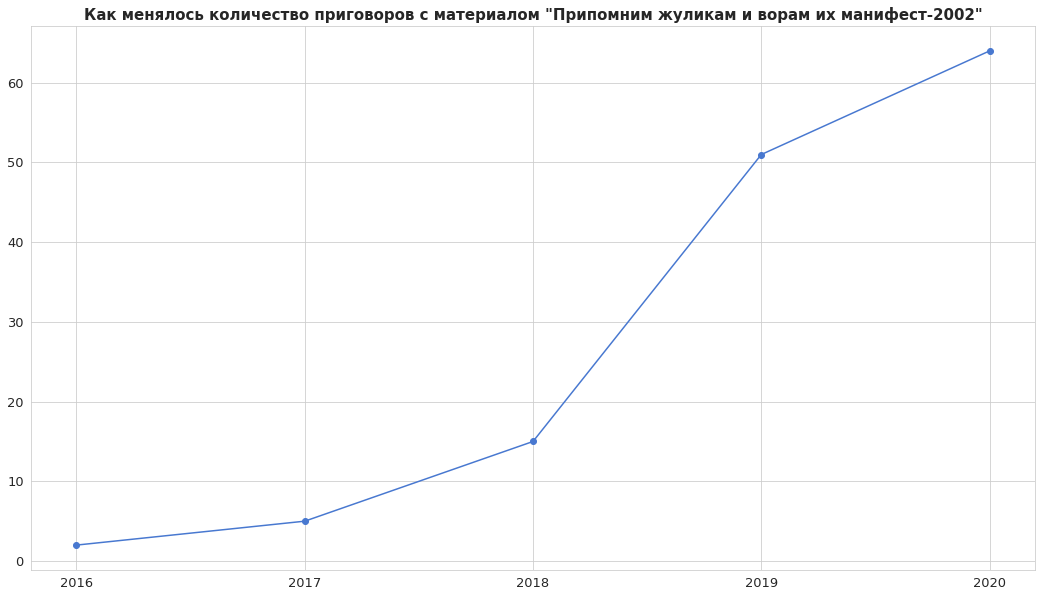

In [ ]:
#@title
one_material_data = pred_mat_df_full[pred_mat_df_full.predicted == '«припомним жуликам и ворам их манифест-2002»']\
                    .groupby('year').count()['predicted']

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(one_material_data.index, one_material_data.values, color=blue, marker='o')
ax.set_title('Как менялось количество приговоров с материалом "Припомним жуликам и ворам их манифест-2002"', size=15).set_weight('semibold')
ax.locator_params(integer=True)
plt.show()

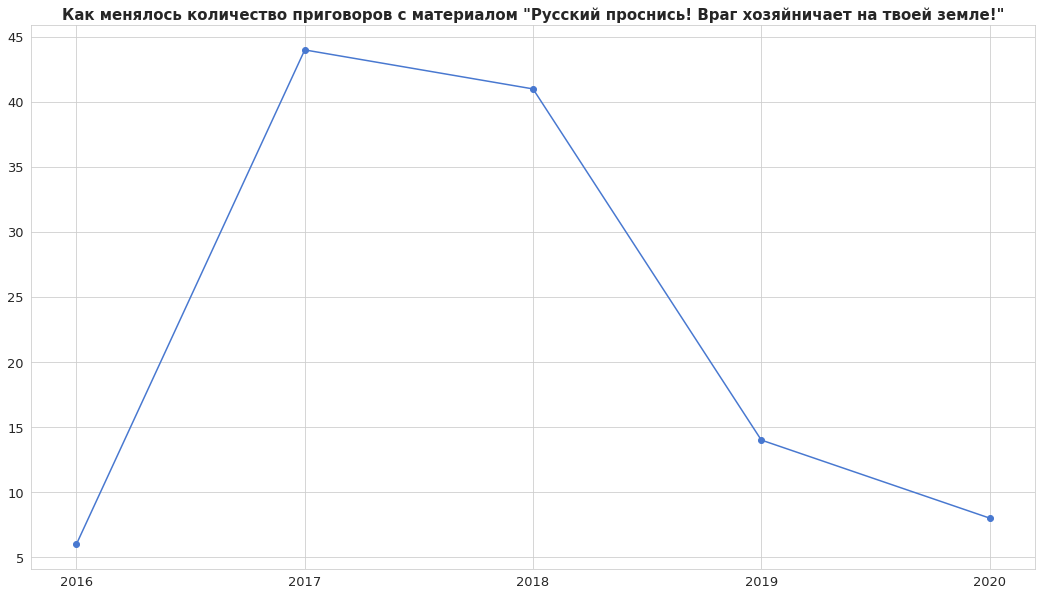

In [ ]:
#@title
one_material_data = pred_mat_df_full[pred_mat_df_full.predicted.str.contains('русский проснись! враг хозяйничает на твоей земле!')]\
                    .groupby('year').count()['predicted']

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(one_material_data.index, one_material_data.values, color=blue, marker='o')
ax.set_title('Как менялось количество приговоров с материалом "Русский проснись! Враг хозяйничает на твоей земле!"', size=15).set_weight('semibold')
ax.locator_params(integer=True)
plt.show()

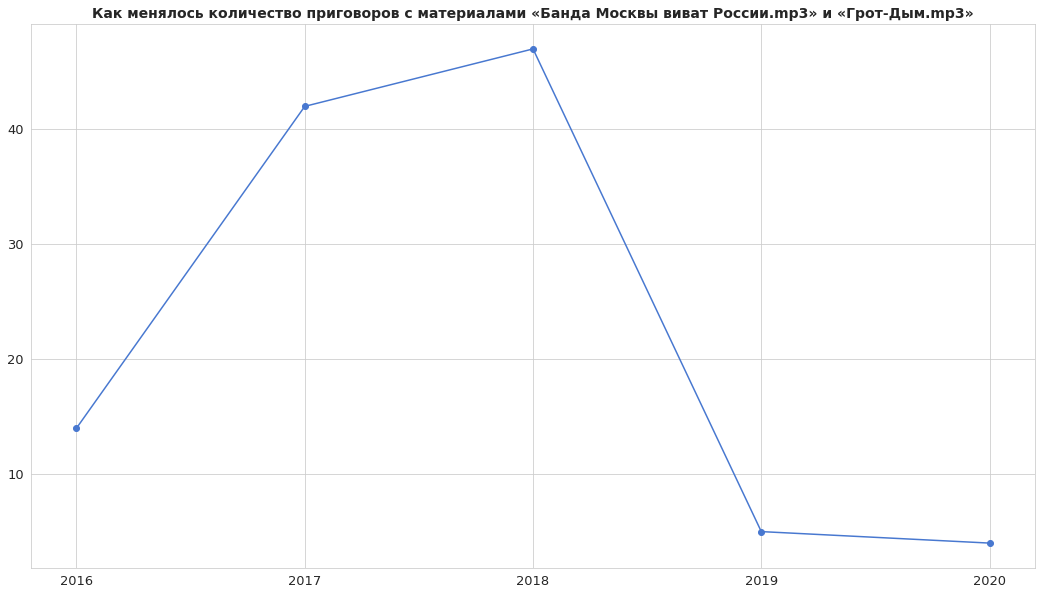

In [ ]:
#@title
one_material_data = pred_mat_df_full[pred_mat_df_full.predicted.str.contains('аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3»')]\
                    .groupby('year').count()['predicted']

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(one_material_data.index, one_material_data.values, color=blue, marker='o')
ax.set_title('Как менялось количество приговоров с материалами «Банда Москвы виват России.mp3» и «Грот-Дым.mp3»', size=14).set_weight('semibold')
ax.locator_params(integer=True)
plt.show()

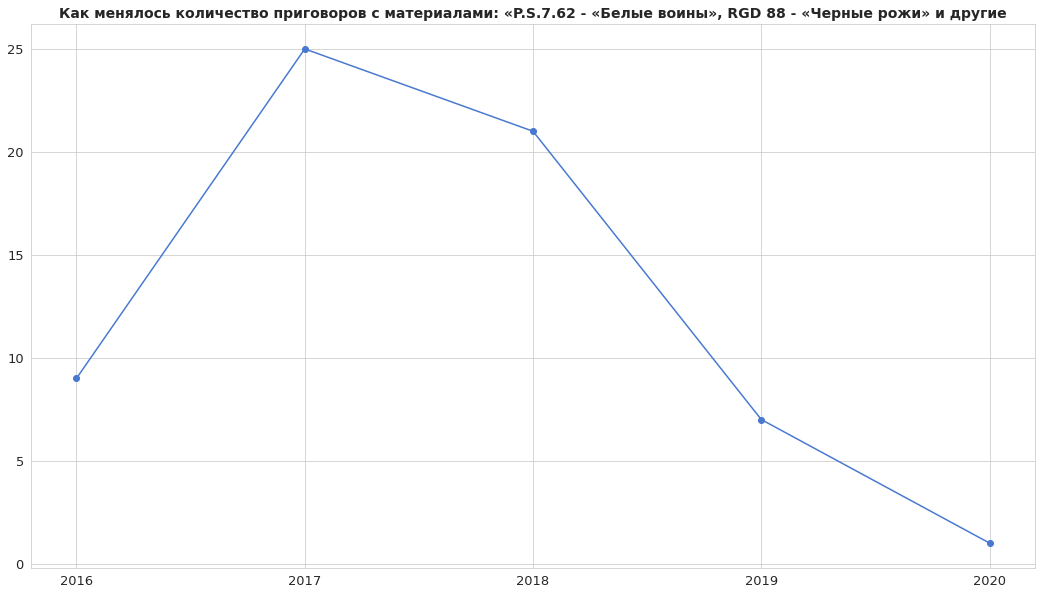

In [ ]:
#@title
one_material_data = pred_mat_df_full[pred_mat_df_full.predicted.str.contains('аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм»')]\
                    .groupby('year').count()['predicted']

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(one_material_data.index, one_material_data.values, color=blue, marker='o')
ax.set_title('Как менялось количество приговоров с материалами: «P.S.7.62 - «Белые воины», RGD 88 - «Черные рожи» и другие', size=14).set_weight('semibold')
ax.locator_params(integer=True)
plt.show()

Ещё одно интересное изменение. Дел с материалами "белого национализма" становится меньше, а количество дел с "кавказским национализмом" наоборот растёт.

Это особенно видно по количествую дел с материалами песен Тимура Муцураева. Эти песни слушали и чеченские сепаратисты, и российские солдаты, остаются одним из главных культурных феноменов войны в Чечне. Но несколько лет назад некоторые произведения Муцураева признали экстремистскими после чего и начался всплеск дел против жителей Чечни и других регионов по 20.29. 

У меня есть гипотеза, что **такие дела используют для запугивания молодых чеченцев**. Её частично подтверждают местные правозащитники.

*Как объяснил нам адвокат Муса Хадисов, по мере усиления действий радикалистов власти начинают применять якобы "превентивные меры". Однако, по его мнению, такого рода действия против молодежи могут только усугубить ситуацию. Хадисов считает, что ни в коем случае нельзя наказывать родителей предполагаемых экстремистов, поскольку те не предупреждают их о своих намерениях. По этой причине осуждение молодых людей по формальным причинам способно лишь усилить лагерь недовольных. Адвокат считает, что привлечение к ответственности за песни Муцураева - это ошибочное понимание "превентивного удара" у представителей власти.*

*Родные одного из привлеченных к ответственности на условиях анонимности рассказали "Кавказ.Реалии", что, разумеется, не проверяли телефон у их 21-летнего сына и историю его поиска в интернете. Они уверены, что **такого рода обвинения со стороны правоохранительных органов практически губит будущее молодого человека**. Несмотря на ничтожное наказание в виде выплаты штрафа, обвинение делает его фигурой, занесенной, по их мнению, в список возможных экстремистов. Родители не исключают, что этот факт подтолкнет их сына к выезду из страны нелегальным путем, чтобы начать свою жизнь заново в чужой стране.*

*Без труда зачисляя молодых людей в "экстремисты" , полиция получает возможность отсчитываться о проделанной работе по предотвращению терроризма и радикализма. Но пока оперативники получают "звездочки" и премии, напряжение в обществе, вопреки их усилиям, растет с каждым вынесенным приговором. *

Также в новостях нашёл, что такими делами в Чечне иногда занимается ФСБ.

*Гудермесский городской суд Чечни признал местного жителя Ахмеда Дускуева виновным в распространении экстремистских материалов в социальной сети "Одноклассники" – он разместил там песню чеченского барда Тимура Муцураева "Проданные крылья Джихада". Согласно официальной версии, Дускуев опубликовал песню в 2017 году. К тому времени композиция "Проданные крылья Джихада" с рядом других песен Муцураева уже два года находилась в списке экстремистских материалов по решению суда. Запрещенный контент на странице Дускуева обнаружил оперуполномоченный отдела ФСБ по Чечне.*


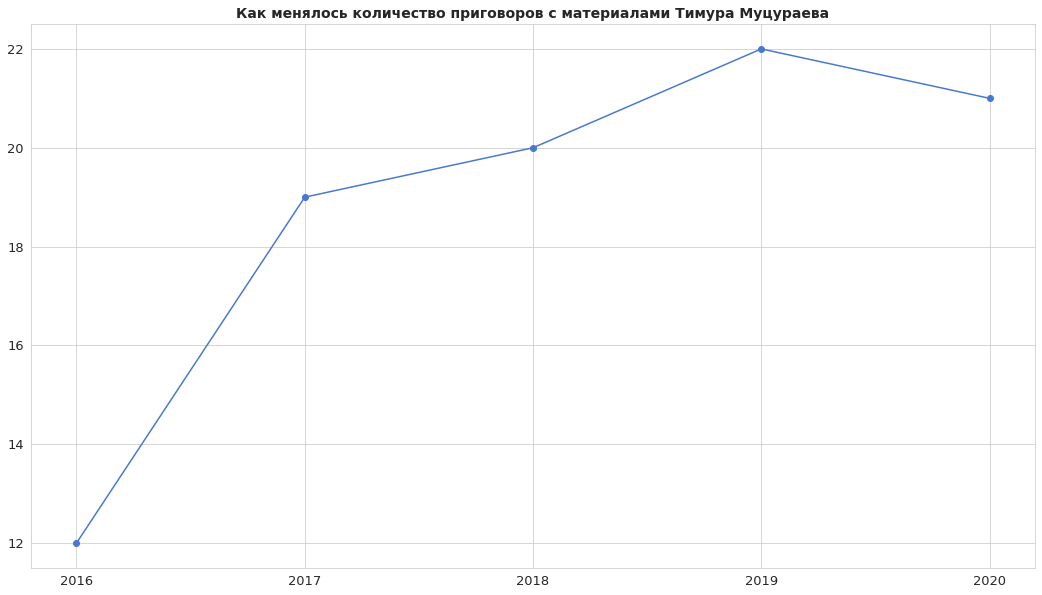

In [ ]:
#@title
one_material_data = pred_mat_df_full[pred_mat_df_full.predicted.str\
                    .contains('информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича')]\
                    .groupby('year').count()['predicted']

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(one_material_data.index, one_material_data.values, color=blue, marker='o')
ax.set_title('Как менялось количество приговоров с материалами Тимура Муцураева', size=14).set_weight('semibold')
ax.locator_params(integer=True)
plt.show()

In [ ]:
#@markdown **Самые распространнёные экстремистские материалы по годам**
extr_define = pred_mat_df_full[pred_mat_df_full.predicted != 'None']
extr_define.groupby(['predicted'])[['case_number']]\
        .count().sort_values(by='case_number', ascending=False).head()

for i in np.unique(extr_define.year):
    print(f'Самые распространённые материалы в {i} году')
    display(extr_define[extr_define.year == i].groupby(['predicted'])[['case_number']]\
        .count().sort_values(by='case_number', ascending=False).head(10).reset_index())
    print('\n')

Самые распространённые материалы в 2014 году


,predicted,case_number
0,"информационные материалы, размещенные в информационно-коммуникационной сети интернет по сетевому адресу www.vk.com/id165111211: – файл «дарья сель...",1




Самые распространённые материалы в 2015 году


,predicted,case_number
0,"текст песни группы «коловрат» под названием «каратель «сс варяг» (song lyrics), автором и исполнителем которой является герасимов денис андреевич (",2
1,"Аудиовизуальные материалы – видеоролики, размещенные Семеновым С.С. в сети «Интернет», содержащиеся в электронных файлах: «!_4TO_SPASLO_AFU.wmv»; ...",1




Самые распространённые материалы в 2016 году


,predicted,case_number
0,музыкальное произведение «радикальный голос» группы «коловрат» (,21
1,dvd-диск с фильмом «чудеса корана» (,20
2,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",17
3,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",14
4,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",14
5,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",13
6,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",13
7,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",12
8,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",11
9,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",10




Самые распространённые материалы в 2017 году


,predicted,case_number
0,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",44
1,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",42
2,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",28
3,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",25
4,музыкальное произведение «радикальный голос» группы «коловрат» (,21
5,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",19
6,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",17
7,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",15
8,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",14
9,информационный материал – видеоролик «тесак против эдуарда багирова. допи-делся (нец.)» временной продолжительностью 8 минут 32 секунды по адресу ...,14




Самые распространённые материалы в 2018 году


,predicted,case_number
0,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",47
1,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",41
2,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",27
3,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",22
4,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",21
5,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",20
6,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",20
7,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",15
8,«припомним жуликам и ворам их манифест-2002»,15
9,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",14




Самые распространённые материалы в 2019 году


,predicted,case_number
0,«припомним жуликам и ворам их манифест-2002»,51
1,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",22
2,"видеофайл «бабушка отматерила чурку» продолжительностью 1 мин., начинающийся со слов «я тебя ведь зарежу....» и заканчивающийся словами «... убью» (",18
3,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",14
4,аудиозапись «аргентина – секс драка (полная версия) 3:54» (,13
5,"текст песни группы «коловрат» под названием «герои роа», автором и исполнителем которой является герасимов денис андреевич (",12
6,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",12
7,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",11
8,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",11
9,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,11




Самые распространённые материалы в 2020 году


,predicted,case_number
0,«припомним жуликам и ворам их манифест-2002»,64
1,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",21
2,"материал, расположенный в сети интернет на сайте « » на странице под названием «марк пельц», с электронным адресом: «http://vk.com/id252604712», а...",12
3,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,10
4,"видеофайл формата mp4 «рабы, сосите пиво..mp4», размещенный в сети интернет на электронной странице http://vkontakte.ru/id4595303 (",10
5,"видеофайл «бабушка отматерила чурку» продолжительностью 1 мин., начинающийся со слов «я тебя ведь зарежу....» и заканчивающийся словами «... убью» (",10
6,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",8
7,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",7
8,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",7
9,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",7


Регионы между собой отличаются не только количеством приговоров, но и тем, за какие экстремитские материалы там судят. На большей территории России преобладают различные неонацистские ролики и песни. А в кавказских республиках песни и стихи, посвящённые борьбе за освобождении Чечни. 

Отдельные же регионы, например как Белгородская область, развернули борьбу с выше упомнятуым роликом "Припомним Единой России...". Лишь по этому материалу там было вынесено порядка сорока приговоров. 

In [ ]:
#@markdown **Наиболее распространённые экстремистские материалы в регионах России**
pd.set_option('max_colwidth', 150)
s = pred_mat_df_only_mats.groupby(['region', 'predicted'])[['sent_text']].count()
regions = list(pred_mat_df_full.region.unique())
regions.sort()

for i in regions:
    display(s.loc[[i]].sort_values(by='sent_text', ascending=False)[:5].reset_index())

,region,predicted,sent_text
0,Алтайский край,«припомним жуликам и ворам их манифест-2002»,21
1,Алтайский край,"видеофайл «бабушка отматерила чурку» продолжительностью 1 мин., начинающийся со слов «я тебя ведь зарежу....» и заканчивающийся словами «... убью» (",17
2,Алтайский край,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",7
3,Алтайский край,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",7
4,Алтайский край,"ранее размещенная на сайте http://vk.com на личной странице пользователя с данными «андрей дуньков» (https://vk.com/dunkovv) видеозапись, располож...",6


,region,predicted,sent_text
0,Амурская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",27
1,Амурская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",10
2,Амурская область,"информационные материалы, распространенные мишуровым в.г. в сети интернет, «обращение к русскому народу», «после этот цирк жидовского абсурда назв...",2
3,Амурская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",2
4,Амурская область,аудиофайл под названием «дюшес - я рисую белым мелом 14/88» (,2


,region,predicted,sent_text
0,Архангельская область,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",2
1,Архангельская область,"интернет-сообщество «мы за вступление россии в сша!», расположенное по электронному адресу: http://vk.com/accession_to_usa и информационные матери...",2
2,Архангельская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",2
3,Архангельская область,тексты семи стихотворений с заголовком «skin heads россии» начинающихся и заканчивающихся словами: «россия прекрасная страна… от разной с*ки на зе...,2
4,Архангельская область,аудиоматериал под названием «мочи чурок!!!» исполнителя «суровый мс» (,1


,region,predicted,sent_text
0,Астраханская область,книга «отведение сомнений» (,5
1,Астраханская область,"печатные (информационные) материалы: 1. брошюра «запретные дела, по отношению к которым люди проявляют небрежность, но которые необходимо избегать...",3
2,Астраханская область,dvd-диск с фильмом «чудеса корана» (,2
3,Астраханская область,"Печатные издания издательства Watch Tower Bible and Tract Society of Pensylvania: «Как достичь счастья в жизни», «На что можно надеяться людям?»; ...",2
4,Астраханская область,"текст песни «я за зож, всех на нож, кто на людей не похож» музыкальной группы аргентина и околорэп, размещенный на указателе страницы сайта «http:...",1


,region,predicted,sent_text
0,Белгородская область,«припомним жуликам и ворам их манифест-2002»,37
1,Белгородская область,"аудиофайл «коловрат – слава россии!!!», размещенный в сети интернет в социальной сети « » на интернет-странице пользователя «влад черняк» по адрес...",7
2,Белгородская область,"видеофайл формата mp4 «рабы, сосите пиво..mp4», размещенный в сети интернет на электронной странице http://vkontakte.ru/id4595303 (",7
3,Белгородская область,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",6
4,Белгородская область,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",5


,region,predicted,sent_text
0,Брянская область,"печатное издание – книга «мертвая вода» концепция общественной безопасности. китеж. державный град россии. 2004, в двух частях – часть 1. историко...",2
1,Брянская область,«припомним жуликам и ворам их манифест-2002»,1
2,Брянская область,"аудиозаписи «саид абу саад бурятский - ибн тейми» от 14.01.2014 года, продолжительностью 55 минут 21 секунду и «саид абу саад бурятский - великие ...",1
3,Брянская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",1
4,Брянская область,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",1


,region,predicted,sent_text
0,Владимирская область,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",4
1,Владимирская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",4
2,Владимирская область,"текст песни: «мой дед был штурмфюрер сс» группы «вандал», размещенный на информационном ресурсе http://yandex.ru/video/ (ссылка url - https://vout...",3
3,Владимирская область,"материалы, расположенные в сети интернет сайта « » на странице http://vk.com/club45276843: содержащиеся в аудиофайлах: «коловрат- в нашем доме поя...",3
4,Владимирская область,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",3


,region,predicted,sent_text
0,Волгоградская область,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",6
1,Волгоградская область,информационные материалы: - аудиозапись под названием «lip soulja - грязная прогулка (москва уже не та).mp3»; - аудиозапись под названием «lip sou...,4
2,Волгоградская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",4
3,Волгоградская область,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",4
4,Волгоградская область,"видеоролики: «велимор-коловат», «коловат-герои рао», format 18- белый вагон», «коловат-mein kampf»; «казнь хачей (теги, скинхеды, самосуд, хачи)»,...",3


,region,predicted,sent_text
0,Вологодская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",3
1,Вологодская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",2
2,Вологодская область,аудиозапись «дюшес я рисую белым мелом 14/88»,2
3,Вологодская область,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",2
4,Вологодская область,"3 аудиозаписи: «железный порядок – белые шнурки», «f.p.g. – ботинки», «коловрат – гордость за расу и нацию» (",2


,region,predicted,sent_text
0,Воронежская область,музыкальное произведение «радикальный голос» группы «коловрат» (,15
1,Воронежская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",11
2,Воронежская область,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",7
3,Воронежская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",6
4,Воронежская область,"текст песни «я за зож, всех на нож, кто на людей не похож» музыкальной группы аргентина и околорэп, размещенный на указателе страницы сайта «http:...",5


,region,predicted,sent_text
0,Город Москва,"лозунг «православие или смерть!», размещенный в интернет-ресурсе www.russiansymbol.ru (",2
1,Город Москва,«припомним жуликам и ворам их манифест-2002»,1
2,Город Москва,"аудиозапись – музыкальная композиция «брунсвиг - это rahowa» продолжительностью 02 мин 16 сек., начинающаяся со слов «нас ждет последний, смертель...",1
3,Город Москва,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",1
4,Город Москва,аудиоматериал под названием «бритоголовые идут» исполнителя «террор и федор волков» (,1


,region,predicted,sent_text
0,За пределами территории РФ,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",1


,region,predicted,sent_text
0,Забайкальский край,«7034f22fb7.360.истишхад – стремление к шахаде саид бурятский. mp4»,1
1,Забайкальский край,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",1
2,Забайкальский край,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",1
3,Забайкальский край,"видеозапись под названием «как я стал скинхедом» распространенную кох и.б., 15.03.1996 года рождения, в сети интернет на персональной странице под...",1
4,Забайкальский край,"видеофильм под названием «гробы для американцев», размещенный как информационный материал на диске dvd-r verbatim № map 638na201636304 (",1


,region,predicted,sent_text
0,Ивановская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",16
1,Ивановская область,"текст песни группы «коловрат» под названием «герои роа», автором и исполнителем которой является герасимов денис андреевич (",6
2,Ивановская область,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",6
3,Ивановская область,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,4
4,Ивановская область,"видеоролики с названием «за..ли кавказцы», «московские скинхеды», «националисты», «обращение к русским», «подольские скины», «россия без ... », «р...",4


,region,predicted,sent_text
0,Иркутская область,"видеоматериал «перевод нашиды 'ахи анта хьуррун' (брат, ты свободен)», размещенный на интернет-ресурсе http//vk.com/id227155313 в социальной сети ...",7
1,Иркутская область,«припомним жуликам и ворам их манифест-2002»,3
2,Иркутская область,"брошюра «сорок хадисов ан-навави», русский перевод под руководством доктора технических, наук а.м. хамди (",2
3,Иркутская область,"аудиозапись – музыкальная композиция «брунсвиг - это rahowa» продолжительностью 02 мин 16 сек., начинающаяся со слов «нас ждет последний, смертель...",1
4,Иркутская область,"аудиофайл с названием «аль каида - послание воинов» длительностью 1 мин. 19 сек., содержащий текст на русском языке, начинающийся со слов: «вы дум...",1


,region,predicted,sent_text
0,Кабардино-Балкарская Республика,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",2
1,Кабардино-Балкарская Республика,"видеофайл «ответ критикам шейх саид абу саад (рахимухуллах)», размещенный в социальной сети « » международной телекоммуникационной сети интернет н...",2
2,Кабардино-Балкарская Республика,"информационный материал (видеофайл) «муджахиды имарата кавказ вилаята нохчийчоь. обращение амира абу усмана и саида бурятского», продолжительность...",2
3,Кабардино-Балкарская Республика,"размещенные волковым к.а. в социальной сети « » по электронному адресу: http: vk.com\kashey_88, материалы, следующего содержания: – фотография рис...",2
4,Кабардино-Балкарская Республика,"Печатные издания издательства Watch Tower Bible and Tract Society of Pensylvania: «Как достичь счастья в жизни», «На что можно надеяться людям?»; ...",1


,region,predicted,sent_text
0,Калининградская область,видеоматериал «звон мечей (салил саварим)» (,2
1,Калининградская область,«припомним жуликам и ворам их манифест-2002»,1
2,Калининградская область,"аудиозаписи с названиями «коловрат (россия принадлежит нам) mp.3, «русский стяг (марш жестокой молодости) mp.3 (",1
3,Калининградская область,"аудиозапись (песня) неизвестного автора, продолжительностью 4 минуты 11 секунд, содержащийся на компакт-диске cd-r, под названием «джихад – аллаху...",1
4,Калининградская область,"видеообращение под наименованием «обращение закарии», обнаруженное и изъятое 04.07.2010 в ходе мониторинга глобальной телекоммуникационной сети ин...",1


,region,predicted,sent_text
0,Калужская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",2
1,Калужская область,видеоматериал под названием «беспредел кавказоидов в хабаровске» также распространяется под названием «беспредел в хабаровске» продолжительностью ...,2
2,Калужская область,"видеоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id6161885 «сергей приходько»: «русский бунт». погромы в москве. (15 декабря 20...",2
3,Калужская область,- «лихие 90-е скинхеды.mp4» – видеофонограмма продолжительностью 02 мин. 01 сек. видеоролик содержит сцену разгрома продуктового рынка толпой скин...,1
4,Калужская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",1


,region,predicted,sent_text
0,Камчатский край,"Печатные издания издательства Watch Tower Bible and Tract Society of Pensylvania: «Как достичь счастья в жизни», «На что можно надеяться людям?»; ...",3
1,Камчатский край,фильм «россия с ножом в спине. еврейский фашизм и геноцид русского народа» (,1


,region,predicted,sent_text
0,Карачаево-Черкесская Республика,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",6
1,Карачаево-Черкесская Республика,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",5
2,Карачаево-Черкесская Республика,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",4
3,Карачаево-Черкесская Республика,"следующие печатные издания: 1. книга салих ас-сухейми «основы веры в свете корана и сунны» [салих ас-сухейми. абд ар-раззак аль-бадр, ибрахим ар-р...",4
4,Карачаево-Черкесская Республика,"визуально-текстовый материал, размещенный в информационно-аналитическом журнале (выпуск №1) исламского государства «исток» в сети интернет на инте...",3


,region,predicted,sent_text
0,Кемеровская область,"аудиофайл «коловрат – слава россии!!!», размещенный в сети интернет в социальной сети « » на интернет-странице пользователя «влад черняк» по адрес...",1
1,Кемеровская область,информационные материалы – аудио-записи: файлы: «бухенвальд флава - убей иммигранта п.у. ленина пакет» - «buhenval'd flava - ubej immigranta p.u. ...,1
2,Кемеровская область,размещенные васильевым р.в. в сети «интернет» на созданной им общедоступной странице «роман <&got> васильев» в социальной сети « » по электронному...,1
3,Кемеровская область,"размещенные пулькиным д.н. в сети «интернет» на сайте www.vkontakte.ru видеозапись «черная коза-)))» (файл «chernaya koza-))).flv»), аудиозапись «...",1
4,Кемеровская область,"текст песни: «мой дед был штурмфюрер сс» группы «вандал», размещенный на информационном ресурсе http://yandex.ru/video/ (ссылка url - https://vout...",1


,region,predicted,sent_text
0,Кемеровская область - Кузбасс,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",8
1,Кемеровская область - Кузбасс,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",7
2,Кемеровская область - Кузбасс,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",5
3,Кемеровская область - Кузбасс,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",4
4,Кемеровская область - Кузбасс,музыкальное произведение «радикальный голос» группы «коловрат» (,3


,region,predicted,sent_text
0,Кировская область,"брошюра «сын «хочет открыть» отца», брошюра «была ли жизнь создана?» (",4
1,Кировская область,размещенный евстафьевым п…с… в социальной сети «http://vkontakte.ru» на интернет-странице http://vk.com/id6693858 аудиоматериал «the киборг – брит...,2
2,Кировская область,"видеоролики с названием «за..ли кавказцы», «московские скинхеды», «националисты», «обращение к русским», «подольские скины», «россия без ... », «р...",2
3,Кировская область,размещенные васильевым р.в. в сети «интернет» на созданной им общедоступной странице «роман <&got> васильев» в социальной сети « » по электронному...,2
4,Кировская область,dvd-диск с фильмом «чудеса корана» (,1


,region,predicted,sent_text
0,Костромская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",6
1,Костромская область,"текст песни группы «коловрат» под названием «честь и кровь», автором и исполнителем которой является герасимов денис андреевич (",6
2,Костромская область,музыкальное произведение «радикальный голос» группы «коловрат» (,5
3,Костромская область,информационный материал – видеоролик «тесак против эдуарда багирова. допи-делся (нец.)» временной продолжительностью 8 минут 32 секунды по адресу ...,3
4,Костромская область,музыкальное произведение «убей мента» группы «психея»» (,2


,region,predicted,sent_text
0,Краснодарский край,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",26
1,Краснодарский край,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",11
2,Краснодарский край,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",6
3,Краснодарский край,"аудиозапись « «25/17 – будь белым», размещенная на интернет – странице http://vkontakte.ru (id15338492) социальной сети « » (",6
4,Краснодарский край,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",5


,region,predicted,sent_text
0,Красноярский край,информационный материал – видеоролик «тесак против эдуарда багирова. допи-делся (нец.)» временной продолжительностью 8 минут 32 секунды по адресу ...,3
1,Красноярский край,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",2
2,Красноярский край,"видеоролики (видеоматериалы), размещенные золотарёвым а.с. в социальной сети «vkontakte.ru» на странице под ником «толян мясной золотарёв» id58050...",2
3,Красноярский край,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",2
4,Красноярский край,"- размещенный на интернет-страницах http://www.youtube.com/watch?v=w7ezztkl1-e, http://www.russobor.com/videomaterialy/-ja-budu-delat-vs-chtoby-pu...",1


,region,predicted,sent_text
0,Курганская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",2
1,Курганская область,"материал, расположенный в сети интернет на сайте « » на странице под названием «марк пельц», с электронным адресом: «http://vk.com/id252604712», а...",2
2,Курганская область,"интернет-сообщество «мы за вступление россии в сша!», расположенное по электронному адресу: http://vk.com/accession_to_usa и информационные матери...",1
3,Курганская область,"размещенные пузанковым п.э. в социальной сети « » видеофайл «куклус клан», а также аудиофайлы с названием «14/88-а ну ка уе..ай отсюда», «крэк-ку-...",1
4,Курганская область,"размещенные на интернет-сайтах http://vk.com/right_kurgan, http://vk.com/skmonolil45 материалы: текст «обращение «правого сектора» к народам росси...",1


,region,predicted,sent_text
0,Курская область,"видеофайл «бабушка отматерила чурку» продолжительностью 1 мин., начинающийся со слов «я тебя ведь зарежу....» и заканчивающийся словами «... убью» (",5
1,Курская область,"видеофайл формата mp4 «рабы, сосите пиво..mp4», размещенный в сети интернет на электронной странице http://vkontakte.ru/id4595303 (",4
2,Курская область,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",3
3,Курская область,"аудиозапись под названием «банда москвы – россия для русских, москва для москвичей» продолжительностью 2 минуты 46 секунд, начинающаяся и заканчив...",2
4,Курская область,"информационный материал в виде текста статьи «правила по созданию агрс (автономных групп российского сопротивления), начиная со слов «молот. я пре...",2


,region,predicted,sent_text
0,Ленинградская область,"видеофайлы «коловрат - футбольный хулиган».mp4, «россия для русских».mp4; аудиофайлы «банда москвы - арийский легион! mp3», «банда москвы - молодо...",1


,region,predicted,sent_text
0,Липецкая область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",2
1,Липецкая область,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",2
2,Липецкая область,видеозаписи: «что ожидаешь ты от дальнейшего будущего нашей страны?» длительностью 3 минуты 41 секунда; «воспитательное видео» длительностью 4 мин...,2
3,Липецкая область,"cтатья «заявление о суде над еврейскими организациями», источник публикации - газета «русская правда» № 30 от 2002 года (",1
4,Липецкая область,визуальные текстовые материалы: «кавказский спортсмен наткнулся на русских школьников»; «скингерл (skingirl)»; «нс демотиваторы»; «борьба за выжив...,1


,region,predicted,sent_text
0,Магаданская область,"текст песни «реп – это кал» рок-группы «коррозия металла», начинающийся со слов: «эй, нигер! рэп – это кал!...» и заканчивающийся словами: «п*здец...",1


,region,predicted,sent_text
0,Московская область,"аудиоматериал «русский стяг - мы идем», длительностью 02 минуты 47 секунд, начинающийся словами: «поднимайтесь братья с нами, знамя русское...» и ...",2
1,Московская область,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,2
2,Московская область,"аудиозапись - фонограмма, обнаруженная 11.10.2011 в сети интернет на сайте « » на странице пользователя «илья белоусов» по адресу: http://vkontakt...",1
3,Московская область,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",1
4,Московская область,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",1


,region,predicted,sent_text
0,Мурманская область,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",3
1,Мурманская область,размещенные васильевым р.в. в сети «интернет» на созданной им общедоступной странице «роман <&got> васильев» в социальной сети « » по электронному...,2
2,Мурманская область,"музыкальная композиция группы «черная экономика и рыночные отношения» - «я хочу, чтоб мусора сосали х...й» (на месте многоточия «у»), размещенная ...",2
3,Мурманская область,- «лихие 90-е скинхеды.mp4» – видеофонограмма продолжительностью 02 мин. 01 сек. видеоролик содержит сцену разгрома продуктового рынка толпой скин...,1
4,Мурманская область,"видеофайлы «слава россии», «слава руси. от сердца к солнцу», размещенные в социальной сети « » в сети интернет, имеющие сетевой адрес www.vk.com/i...",1


,region,predicted,sent_text
0,Нижегородская область,"видеоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id6161885 «сергей приходько»: «русский бунт». погромы в москве. (15 декабря 20...",2
1,Нижегородская область,"информационный материал - видеоролик «за что мир ненавидит жидов?», размещенный в сети интернет (",2
2,Нижегородская область,"аудио-ролик «тимур муцураев_-_ иншааллаh сады нас ждут» длительностью 6 минут 26 секунд, размещенный в разделе «аудиозаписи» на странице пользоват...",1
3,Нижегородская область,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",1
4,Нижегородская область,"аудиофайл «моя толерантность» размером 4,84 мб (5 076 200 байт), содержащий аудиозапись общей длительностью 05 минут 17 секунд, размещенный на инт...",1


,region,predicted,sent_text
0,Новгородская область,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",2
1,Новгородская область,"Книга: Послание о народе Нохчи» [Текст]/ Р. Ибрагимов. - Элиста: ЗАОр «НПП Джангар», 2014.-236 с.: илл. (апелляционное определение Судебной коллег...",1
2,Новгородская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",1
3,Новгородская область,"видеоролик «банда москвы виват, россия! «отмахали цунора на nacxy.wmv» (",1
4,Новгородская область,"книга «очищение сердца и тела от грязи многобожия и неверия» автор ахмад ибн хаджар аллу бутами, первое издание центра переводов «тахвиду-с-суфуф»...",1


,region,predicted,sent_text
0,Новосибирская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",2
1,Новосибирская область,"Аудиовизуальные материалы – видеоролики, размещенные Семеновым С.С. в сети «Интернет», содержащиеся в электронных файлах: «!_4TO_SPASLO_AFU.wmv»; ...",1
2,Новосибирская область,"видеоролики (видеоматериалы) с названиями: «песня тирольских казаков полено. fnv», «a00e7d31da.480mp3» «фюрер кощей передает приветы своим почитат...",1
3,Новосибирская область,"видеоролики (видеоматериалы), размещенные золотарёвым а.с. в социальной сети «vkontakte.ru» на странице под ником «толян мясной золотарёв» id58050...",1
4,Новосибирская область,"книга иман мухйи-д-дин абу закарийа бин шараф ан-навави «сады праведных»/перевод с арабского а.нирша. –м.:издатель эжаев, 2008 (",1


,region,predicted,sent_text
0,Омская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",18
1,Омская область,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",11
2,Омская область,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",8
3,Омская область,информационные материалы: - аудиозапись под названием «lip soulja - грязная прогулка (москва уже не та).mp3»; - аудиозапись под названием «lip sou...,7
4,Омская область,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",6


,region,predicted,sent_text
0,Оренбургская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",3
1,Оренбургская область,- «лихие 90-е скинхеды.mp4» – видеофонограмма продолжительностью 02 мин. 01 сек. видеоролик содержит сцену разгрома продуктового рынка толпой скин...,1
2,Оренбургская область,"информационные материалы, распространенные и хранящиеся в сети интернет по электронным адресам: видеофайл «русские скины!!! россия для русских!!»,...",1
3,Оренбургская область,тексты семи стихотворений с заголовком «skin heads россии» начинающихся и заканчивающихся словами: «россия прекрасная страна… от разной с*ки на зе...,1
4,Оренбургская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",1


,region,predicted,sent_text
0,Орловская область,"видеоролик под названием «обращение к чуркам», размещенный в международной компьютерной сети «интернет» в социальной сети « » на странице курмакае...",2
1,Орловская область,музыкальное произведение «радикальный голос» группы «коловрат» (,2
2,Орловская область,"аудиофайл «монгол шуудан – бей жидов – спасай россию!», размещенный 05 мая 2010 г., продолжительностью 01 минута 41 секунда",1
3,Орловская область,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",1
4,Орловская область,"брошюра «свидетели иеговы кто они? во что они верят?» изд. watch tower bible and tract society of new york, inc international bible students assoc...",1


,region,predicted,sent_text
0,Пензенская область,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,3
1,Пензенская область,видеофайлы: fuck the red.wmv; romper stomper.wmv; абычный антифошизм. wmv; akm.wmv; акция в метро.mpg; акция в электричке.wmv; антипутин. wmv; ант...,2
2,Пензенская область,"Аудиовизуальные материалы «Железный порядок», «Железный порядок – национал социалисты», «Железный порядок – Белые Шнурки», «Железный порядок – Ски...",2
3,Пензенская область,"текст песни группы «коловрат» под названием «герои роа», автором и исполнителем которой является герасимов денис андреевич (",2
4,Пензенская область,"брошюра «ценности рамазана» автора шейхуль хадис маулана мухаммад закария кандехлеви, «религиозное просвещение», казань, 2004 (",2


,region,predicted,sent_text
0,Пермский край,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",19
1,Пермский край,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",11
2,Пермский край,"видеофайл «русский, очнись! против тебя идет война!», файл «2ee9cab98f4380031246.vk», формат «.flv», размером 14 мб, продолжительностью 6 мин. 19 ...",5
3,Пермский край,"видеоролик под названием «обращение к чуркам», размещенный в международной компьютерной сети «интернет» в социальной сети « » на странице курмакае...",5
4,Пермский край,видеофайл «максим базылев – скромный герой» размещенный в сети интернет по следующим электронным адресам: https://www.youtube.com/watch?v=fsqq5umg...,4


,region,predicted,sent_text
0,Приморский край,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,2
1,Приморский край,аудиозапись «аргентина – секс драка (полная версия) 3:54» (,1
2,Приморский край,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",1
3,Приморский край,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",1
4,Приморский край,"видеоролик «приказ амира имарата кавказ докку абу усмана по вопросу о статусе гражданского населения россии», продолжительностью 4 минуты 03 секун...",1


,region,predicted,sent_text
0,Псковская область,«припомним жуликам и ворам их манифест-2002»,16
1,Псковская область,информационный материал – видеоролик «тесак против эдуарда багирова. допи-делся (нец.)» временной продолжительностью 8 минут 32 секунды по адресу ...,9
2,Псковская область,фильм «россия с ножом в спине. еврейский фашизм и геноцид русского народа» (,3
3,Псковская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",3
4,Псковская область,"аудиоматериал «25/17 - линия фронта», длительностью 03 минуты 42 секунды, начинающийся словами: «бомбардировщики не бомбят, танки не наступают...»...",3


,region,predicted,sent_text
0,Республика Адыгея,«припомним жуликам и ворам их манифест-2002»,1
1,Республика Адыгея,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",1
2,Республика Адыгея,книга шейха али аль-тантауи «общее представление об исламе» (,1


,region,predicted,sent_text
0,Республика Алтай,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",2
1,Республика Алтай,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",2
2,Республика Алтай,"видеофайл с названием: «скины мстят» (http://vkontakte.ru/video 41789778_155430560, размещенный в международной компьютерной сети «интернет» на ин...",1


,region,predicted,sent_text
0,Республика Башкортостан,dvd-диск с фильмом «чудеса корана» (,20
1,Республика Башкортостан,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",6
2,Республика Башкортостан,"видеозаписи с именами: «_читай!_абу юсуф. обращение к русским и украинцам. youtube.mp4» и «я католичка и я попаду в ад_-youtube.mp4», размещенные ...",3
3,Республика Башкортостан,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",3
4,Республика Башкортостан,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",3


,region,predicted,sent_text
0,Республика Бурятия,«припомним жуликам и ворам их манифест-2002»,2
1,Республика Бурятия,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",2
2,Республика Бурятия,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",2
3,Республика Бурятия,"статья под названием «обращение к сибирякам и россиянам», начинающаяся словами «дорогие земляки-сибиряки и соотечественники россияне!», и заканчив...",2
4,Республика Бурятия,"видеоролик под названием «моджахеды, шахиды, чечня», размещенный 22 апреля 2009 г. в международной компьютерной сети «интернет» на информационной ...",1


,region,predicted,sent_text
0,Республика Дагестан,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",6
1,Республика Дагестан,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,3
2,Республика Дагестан,"видеоролик под названием «дагестанцы поддерживают террористов», продолжительностью 02 мин. 23 сек., тип файла: тр4, размер 67 897 044 байт, начина...",2
3,Республика Дагестан,текст песни «тимур муцураев - мы жизни истину познали» размещенный на странице пользователя (в социальной сети « ») «мансур нихло» имеющий электро...,2
4,Республика Дагестан,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",2


,region,predicted,sent_text
0,Республика Ингушетия,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",2
1,Республика Ингушетия,"видеофайл «гелаевский спецназ», расположенный на компакт-диске «sony» формата cd-r с надписью «наров» (",1


,region,predicted,sent_text
0,Республика Калмыкия,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",3
1,Республика Калмыкия,"аудиофайл «коловрат – слава россии!!!», размещенный в сети интернет в социальной сети « » на интернет-странице пользователя «влад черняк» по адрес...",2
2,Республика Калмыкия,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",2
3,Республика Калмыкия,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,2
4,Республика Калмыкия,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",1


,region,predicted,sent_text
0,Республика Карелия,"аудиозапись под названием «тимур муцураев - 12000 муджахедов.mр3» продолжительностью 04 мин. 45 сек., начинающаяся словами: «багрово на закате сол...",2
1,Республика Карелия,аудиофайл под названием «дюшес - я рисую белым мелом 14/88» (,2
2,Республика Карелия,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",2
3,Республика Карелия,видеоматериал «адольф гитлер.альбом № 2» под музыку коловрат» размещенный в сети интернет на сайте http://vk.com/videos169482104?q=адольф %20гитле...,2
4,Республика Карелия,"текст песни группы «коловрат» под названием «честь и кровь», автором и исполнителем которой является герасимов денис андреевич (",2


,region,predicted,sent_text
0,Республика Коми,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",4
1,Республика Коми,"аудиозапись, размещенная в информационно-телекоммуникационной сети интернет на личной странице пользователя под псевдонимом «денис нетолерантный» ...",1
2,Республика Коми,"аудиофайл тимура муцураева под названием «держись, россия! мы идем!», размещенный на странице пользователя «аслан одинокий волк масхадов», располо...",1
3,Республика Коми,видеоматериал «звон мечей (салил саварим)» (,1
4,Республика Коми,"видеоматериал, содержащийся в видеофайле под названием: «обращение амира ик доку абу усмана и амира супьяна к моджахедам идеаль-урала, вилайятам т...",1


,region,predicted,sent_text
0,Республика Крым,аудиозапись «дюшес я рисую белым мелом 14/88»,2
1,Республика Крым,размещенные боженковым павлом олеговичем в сети «интернет» на сайте www.vkontakkte.ru следующие материалы: 1) видеоролик «крэг-вечный рай (crack-e...,2
2,Республика Крым,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",1
3,Республика Крым,видеоролик «почему они обвиняют хизб-ут-тахрир в экстремизме?»),1
4,Республика Крым,"материал, расположенный в сети интернет на сайте « » на странице под названием «марк пельц», с электронным адресом: «http://vk.com/id252604712», а...",1


,region,predicted,sent_text
0,Республика Марий Эл,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",13
1,Республика Марий Эл,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",6
2,Республика Марий Эл,«припомним жуликам и ворам их манифест-2002»,4
3,Республика Марий Эл,"аудиозапись « «25/17 – будь белым», размещенная на интернет – странице http://vkontakte.ru (id15338492) социальной сети « » (",2
4,Республика Марий Эл,"текст песни группы «коловрат» под названием «честь и кровь», автором и исполнителем которой является герасимов денис андреевич (",2


,region,predicted,sent_text
0,Республика Мордовия,"видеофайл «бабушка отматерила чурку» продолжительностью 1 мин., начинающийся со слов «я тебя ведь зарежу....» и заканчивающийся словами «... убью» (",3
1,Республика Мордовия,"текстовая часть аудиозаписи «хорсс - злей, значит сильней», длительностью 03 минуты 03 секунды, начинающаяся словами: «история улиц, написанная кр...",2
2,Республика Мордовия,"видеоролик, продолжительностью 0 минут 27 секунд с заглавием «чурки: «мы приехали в москву порядок наводить» (",2
3,Республика Мордовия,"Печатные издания издательства Watch Tower Bible and Tract Society of Pensylvania: «Как достичь счастья в жизни», «На что можно надеяться людям?»; ...",2
4,Республика Мордовия,"Видеоматериалы «Россия», «слава руси», «ГРОТ-Просыпайтесь», «Злодеяние жидов в России», «Настоящей Полковник Владимир КВАЧКОВ», «Полковник В.В. Кв...",1


,region,predicted,sent_text
0,Республика Саха (Якутия),"брошюра абдуррахмана бин абдулькарим аш-шиха, офис по содействию в призыве, наставлении и просвещении этнических меньшинств в районе рабва г.эр-ри...",3
1,Республика Саха (Якутия),"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",1
2,Республика Саха (Якутия),брошюра д-ра шерифа абдул-азым «женщина в исламе и в иудейско-христианском мире (между мифами и реальностью)» издательство «engineering house pres...,1
3,Республика Саха (Якутия),"видеоролик под названием: «адольф гитлер, человек, который пошел против банка», продолжительностью 6 минут 13 секунд, размер 95,3 мб, сопровождающ...",1
4,Республика Саха (Якутия),"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",1


,region,predicted,sent_text
0,Республика Северная Осетия-Алания,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",5
1,Республика Северная Осетия-Алания,"аудио-ролик «тимур муцураев_-_ иншааллаh сады нас ждут» длительностью 6 минут 26 секунд, размещенный в разделе «аудиозаписи» на странице пользоват...",4
2,Республика Северная Осетия-Алания,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",3
3,Республика Северная Осетия-Алания,"материалы потребительского общества и нейро©общества «колоград» на звуковом файле «семинар.mav», на cd-диске с маркировками «smartbuy» «cd-r», «52...",3
4,Республика Северная Осетия-Алания,"материалы, размещенные на ресурсе по электронному адресу: http://www.iw.org/ru/пyбликaции/книги/?contentlanguagefilter=ru&pubfilter=gt&sortby=1под...",2


,region,predicted,sent_text
0,Республика Татарстан,"книга ""книга единобожия"", автор - мухаммад ибн сулейман ат-тамими, источник публикации - некоммерческое партнерство ""издательский дом ""бадр"",",4
1,Республика Татарстан,"книга «основы веры в свете корана и сунны» (автор салих ас-сухейми) – м., издатель а.н. факихи, а. аль-гамиди. – 3-е изд., исп., допол. – м.: изда...",4
2,Республика Татарстан,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",3
3,Республика Татарстан,"видеозапись, под названием «бабушка – скинхед.mp 4», продолжительностью 10мин. 09 сек., начинающаяся со слов «здрасте бабуль, а чего продаете?», з...",3
4,Республика Татарстан,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",2


,region,predicted,sent_text
0,Республика Тыва,"видеофайл формата mp4 «русские парни против хачей русские сила..mp4», размещенный в сети интернет на электронной странице http://vkontakte.ru/id45...",2


,region,predicted,sent_text
0,Республика Хакасия,"видеофайл формата mp4 «русские парни против хачей русские сила..mp4», размещенный в сети интернет на электронной странице http://vkontakte.ru/id45...",9
1,Республика Хакасия,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",8
2,Республика Хакасия,"видеоклип «последнее интервью приморских партизан», размещенный в международной компьютерной сети интернет на сайте социальной сети www.vkontakte....",3
3,Республика Хакасия,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,2
4,Республика Хакасия,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",2


,region,predicted,sent_text
0,Ростовская область,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",2
1,Ростовская область,"аудиозаписи с названиями «коловрат (россия принадлежит нам) mp.3, «русский стяг (марш жестокой молодости) mp.3 (",1
2,Ростовская область,"аудиофайл под названием «доберман - славянский союз», размещенный на интернет - странице http://vkontakte.ru/ariec_89, на интернет сайте www. vkon...",1
3,Ростовская область,"видеоролик под названием «скин-герлы», размещенный в социальной сети « » сети интернет, имеющий сетевой адрес https://vk.com/id214998889 (",1
4,Ростовская область,интернет-ресурс (сайт): http://abusalima770.blogspot.ru/ – блог под названием «рай под тенью сабель» (,1


,region,predicted,sent_text
0,Рязанская область,«припомним жуликам и ворам их манифест-2002»,15
1,Рязанская область,музыкальное произведение «радикальный голос» группы «коловрат» (,5
2,Рязанская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",3
3,Рязанская область,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",3
4,Рязанская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",3


,region,predicted,sent_text
0,Самарская область,«припомним жуликам и ворам их манифест-2002»,5
1,Самарская область,"цикл фильмов «игры богов», состоящий из восьми актов: «театр», «артисты и зрители», «эстетика», «общение. музыка. слово», «правильное образование»...",3
2,Самарская область,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",3
3,Самарская область,"информация, размещенная на электронной странице группы «партия националистов. русские забайкальский край» https://vk.com/club8720443 сайта vk.com ...",2
4,Самарская область,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",2


,region,predicted,sent_text
0,Саратовская область,"аудиофайлы «банды москвы-молодой скинхэд», «коловрат-герои р.о.а.» «коловрат- кровь патриотов», «коловрат-радикальный голос», «коловрат-россия», в...",3
1,Саратовская область,"Аудиовизуальные материалы «Железный порядок», «Железный порядок – национал социалисты», «Железный порядок – Белые Шнурки», «Железный порядок – Ски...",2
2,Саратовская область,"аудиоматериал «25-17 - просыпайтесь!», длительностью 02 минуты 49 секунд, начинающийся словами: «у тебя не бывало ощущения. что ничего хорошего......",2
3,Саратовская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",2
4,Саратовская область,видеофайлы: fuck the red.wmv; romper stomper.wmv; абычный антифошизм. wmv; akm.wmv; акция в метро.mpg; акция в электричке.wmv; антипутин. wmv; ант...,2


,region,predicted,sent_text
0,Сахалинская область,видеоролик «самоубийство белой расы» (,2
1,Сахалинская область,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",1


,region,predicted,sent_text
0,Свердловская область,"Видеоматериалы «Россия», «слава руси», «ГРОТ-Просыпайтесь», «Злодеяние жидов в России», «Настоящей Полковник Владимир КВАЧКОВ», «Полковник В.В. Кв...",1
1,Свердловская область,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",1
2,Свердловская область,"брошюра абдуррахмана бин абдулькарим аш-шиха, офис по содействию в призыве, наставлении и просвещении этнических меньшинств в районе рабва г.эр-ри...",1
3,Свердловская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",1
4,Свердловская область,книга «истинная религия аллаха» доктора а.а.в. филипс и диск «обязанности мусульманки» (лекция халида ясина) (,1


,region,predicted,sent_text
0,Смоленская область,"3 аудиозаписи: «железный порядок – белые шнурки», «f.p.g. – ботинки», «коловрат – гордость за расу и нацию» (",6
1,Смоленская область,«припомним жуликам и ворам их манифест-2002»,3
2,Смоленская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",2
3,Смоленская область,"текстовая часть аудиозаписи «хук справа - про толерантность», длительностью 02 минуты 52 секунды, начинающаяся словами: «дольче габбана вполне по ...",2
4,Смоленская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",2


,region,predicted,sent_text
0,Ставропольский край,«припомним жуликам и ворам их манифест-2002»,7
1,Ставропольский край,"следующие печатные издания: 1. книга салих ас-сухейми «основы веры в свете корана и сунны» [салих ас-сухейми. абд ар-раззак аль-бадр, ибрахим ар-р...",3
2,Ставропольский край,"видеофильм под названием «гробы для американцев», размещенный как информационный материал на диске dvd-r verbatim № map 638na201636304 (",3
3,Ставропольский край,"книга «чему на самом деле учит библия?» изд.watch tower bible and tract society of new york, inc. brooklyn, new york, u.s.a. 2005 (",3
4,Ставропольский край,книга марцинкевича м.с. «реструкт! книга максима тесака» 2012 – 511с. (,2


,region,predicted,sent_text
0,Тамбовская область,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",3
1,Тамбовская область,"3 аудиозаписи: «железный порядок – белые шнурки», «f.p.g. – ботинки», «коловрат – гордость за расу и нацию» (",2
2,Тамбовская область,"видеофайл «россия для русских!!!!! мы победим – кавказцы проиграют эту войну» продолжительностью 01 мин. 54 сек., который состоит из видеоряда и н...",2
3,Тамбовская область,"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",2
4,Тамбовская область,"аудиозапись под названием «банда москвы – россия для русских, москва для москвичей» продолжительностью 2 минуты 46 секунд, начинающаяся и заканчив...",1


,region,predicted,sent_text
0,Тверская область,"материал, расположенный в сети интернет на сайте « » на странице под названием «марк пельц», с электронным адресом: «http://vk.com/id252604712», а...",2
1,Тверская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",1
2,Тверская область,"видеофайлы «коловрат - футбольный хулиган».mp4, «россия для русских».mp4; аудиофайлы «банда москвы - арийский легион! mp3», «банда москвы - молодо...",1
3,Тверская область,"печатное издание «усуль аль-иман. постулаты мусульманской веры», ооо «издатель эжаев а.к.», подписано в печать 08.06.2011 г. (",1
4,Тверская область,"речь в храме отца василия - новикова в.н., размещенную как информационный материал на диске dvd-r № map 702ll 13174652 а2 с надписью на лицевой ст...",1


,region,predicted,sent_text
0,Томская область,"Аудиовизуальные материалы «Железный порядок», «Железный порядок – национал социалисты», «Железный порядок – Белые Шнурки», «Железный порядок – Ски...",1
1,Томская область,аудиозапись «дюшес я рисую белым мелом 14/88»,1
2,Томская область,"аудиозапись под названием «скинхед», исполнитель «коррозия металла» (",1
3,Томская область,"аудиоматериал «русский стяг - мы идем», длительностью 02 минуты 47 секунд, начинающийся словами: «поднимайтесь братья с нами, знамя русское...» и ...",1
4,Томская область,аудиофайл под названием «дюшес - я рисую белым мелом 14/88» (,1


,region,predicted,sent_text
0,Тульская область,аудиозапись «аргентина – секс драка (полная версия) 3:54» (,6
1,Тульская область,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",5
2,Тульская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",4
3,Тульская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",4
4,Тульская область,"размещенные в сети интернет, в том числе на веб сервисе сайта «vk.com» аудиозаписи «хук справа – генерал ермолов» длительностью от 03 минут 00 сек...",3


,region,predicted,sent_text
0,Тюменская область,"видеоролик «обращение бойцов славянского союза к русским», размещенный гончаровым о.в. на интернет-странице по адресу http://vkontakte.ru/id506921...",3
1,Тюменская область,"Аудиовизуальные материалы «Железный порядок», «Железный порядок – национал социалисты», «Железный порядок – Белые Шнурки», «Железный порядок – Ски...",1
2,Тюменская область,"аудиозапись «с.п.р.о.т. – расист.mp3», размещенный в социальной сети « » (",1
3,Тюменская область,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",1
4,Тюменская область,"видеоматериал с наименованием «армянин гонит на чеченцев дагов ингушей нетипичная махачкала», а также имеющий разные названия на разных сайтах («а...",1


,region,predicted,sent_text
0,Удмуртская Республика,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",3
1,Удмуртская Республика,"текст песни группы «коловрат» под названием «герои роа», автором и исполнителем которой является герасимов денис андреевич (",3
2,Удмуртская Республика,"текст песни группы «коловрат» под названием «каратель «сс варяг» (song lyrics), автором и исполнителем которой является герасимов денис андреевич (",2
3,Удмуртская Республика,- «правые ребята (далее следует нецензурное выражение) таджиков. .mp4» – видеофонограмма продолжительностью 00 мин. 31 сек. видеоролик содержит сц...,1
4,Удмуртская Республика,музыкальное произведение «радикальный голос» группы «коловрат» (,1


,region,predicted,sent_text
0,Ульяновская область,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",9
1,Ульяновская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",7
2,Ульяновская область,"видеоматериал - «ислам победит!», продолжительностью около 1 минуты 20 секунд (",6
3,Ульяновская область,«припомним жуликам и ворам их манифест-2002»,5
4,Ульяновская область,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,5


,region,predicted,sent_text
0,Хабаровский край,"аудиокомпозиция «коррозия металла-бей чертей» группы «коррозия металла», размещенная на интернет-сайте www.bisound.com (",5
1,Хабаровский край,музыкальное произведение «радикальный голос» группы «коловрат» (,2
2,Хабаровский край,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",2
3,Хабаровский край,"видеоролик под названием «русский выбирает нс», продолжительностью 01 мин. 06 сек., размещенный на интернет-странице по электронному адресу: http:...",2
4,Хабаровский край,"аудиозаписи: «околореп-зигазага, ой», «коловрат-зига зага пам пам)))», размещенные в социальной сети « » (",2


,region,predicted,sent_text
0,Ханты-Мансийский автономный округ - Югра (Тюменская область),"материал, расположенный в сети интернет на сайте « » на странице под названием «марк пельц», с электронным адресом: «http://vk.com/id252604712», а...",11
1,Ханты-Мансийский автономный округ - Югра (Тюменская область),видеоматериал под названием «вот так надо чурок (нецензурная брань – прим. «бить»)! гниль (нецензурная брань – прим. «чернокожие»)!!!» продолжител...,6
2,Ханты-Мансийский автономный округ - Югра (Тюменская область),видеоматериал «звон мечей (салил саварим)» (,6
3,Ханты-Мансийский автономный округ - Югра (Тюменская область),"«видеоролик под названиями - правду говорят скины», «я не хочу быть толерантным» и «видео о толерантности», продолжительностью 6 минут 5 секунд, н...",5
4,Ханты-Мансийский автономный округ - Югра (Тюменская область),"текстовая часть аудиозаписи «p.s.7.62 - улица кадырова» длительностью 03 минуты 18 секунд, начинающаяся словами: «во столице есть теперь улица кад...",4


,region,predicted,sent_text
0,Челябинская область,"книги: 1) «крепость мусульманина. из слов поминания аллаха, встречающихся в коране и сунне», собрал и подготовил к изданию нуждающийся в аллахе вс...",6
1,Челябинская область,"книга ф.байрамовой «тропою знаний к истине», на 149 страницах, 2007 года издания, издательская группа «сад» (",2
2,Челябинская область,«это видео (кондопога) запрещено к показу фсб» (,1
3,Челябинская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",1
4,Челябинская область,"текст песни группы «коловрат» под названием «синяя болезнь», автором и исполнителем которой является герасимов денис андреевич (",1


,region,predicted,sent_text
0,Чеченская Республика,"аудиоматериалы, размещенные на интернет-ресурсе http://vkontakte.ru/id94170133: «они ушли», «таухид», «удар клинка», «чечня в огне», «шахид» (",11
1,Чеченская Республика,"информационные материалы - записи песен, предположительно, автора и исполнителя муцураева тимура хамзатовича (хасановича), содержащиеся на носител...",8
2,Чеченская Республика,"размещенной в сети «интернет» стихотворный текст под названием «ломоносов. ода на взятие иерусалима», начинающийся со слов «восторг внезапный ум п...",6
3,Чеченская Республика,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",4
4,Чеченская Республика,текст песни и видеоролик «тимур муцураев – исламская умма» продолжительностью около 5 мин. 40 сек. (,4


,region,predicted,sent_text
0,Чувашская Республика - Чувашия,"аудиозапись под названием «русский стяг (русь великая), mp3, аудиозапись под названием «русский стяг (стальные орлы), mp3» (",2
1,Чувашская Республика - Чувашия,"аудиофайл (аудиозапись) «хор сс – россия для русских.mp3», размещенный в сети интернет в социальной сети «вконстакте» на интернет-странице пользов...",2
2,Чувашская Республика - Чувашия,"информация, размещенная на электронной странице группы «партия националистов. русские забайкальский край» https://vk.com/club8720443 сайта vk.com ...",2
3,Чувашская Республика - Чувашия,"Видеоматериалы «Россия», «слава руси», «ГРОТ-Просыпайтесь», «Злодеяние жидов в России», «Настоящей Полковник Владимир КВАЧКОВ», «Полковник В.В. Кв...",1
4,Чувашская Республика - Чувашия,"информационный материал, размещенный в глобальной информационной сети интернет, в форме видеозаписи под названием «запрещенная на тв социальная ре...",1


,region,predicted,sent_text
0,Ямало-Ненецкий автономный округ,"аудиофайл тимура муцураева под названием «рай под тенью сабель», размещенный на странице пользователя «аслан одинокий волк масхадов», расположенно...",6
1,Ямало-Ненецкий автономный округ,"видеофайлы «мусульмане, где вы??? – проданные крылья джихада», «тимур муцураев – иерасулим», «чеченцы о войне в чечне», «шамиль басаев – правда пр...",5
2,Ямало-Ненецкий автономный округ,"видеозапись «тимур муцураев – иерусалим *1998 г.*» длительностью 9 минут 37 секунд, размещенная на сайте www.youtube.com по электронному адресу: h...",4
3,Ямало-Ненецкий автономный округ,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",4
4,Ямало-Ненецкий автономный округ,"видеофайл с названием: «банда москвы - виват, россия!» (http://vkontakte.ru/ video41789778_161018550), размещенный в международной компьютерной се...",2


,region,predicted,sent_text
0,Ярославская область,"информация в виде изображения, содержащего надпись «русский проснись! враг хозяйничает на твоей земле!», изображения, содержащего надписи «я патри...",2
1,Ярославская область,"текст песни группы «коловрат» под названием «честь и кровь», автором и исполнителем которой является герасимов денис андреевич (",2
2,Ярославская область,"текст песни группы «коловрат» под названием «качай железо!», автором и исполнителем которой является герасимов денис андреевич (",2
3,Ярославская область,аудиофайл под названием «дюшес - я рисую белым мелом 14/88» (,2
4,Ярославская область,"аудиофайлы с названиями «банда москвы виват россии.mp.3» и «грот-дым.mp3» (url-адрес: http:vk.com/id6641584, социальная сеть « ») (",2


,region,predicted,sent_text
0,город Санкт-Петербург,размещенные боженковым павлом олеговичем в сети «интернет» на сайте www.vkontakkte.ru следующие материалы: 1) видеоролик «крэг-вечный рай (crack-e...,2
1,город Санкт-Петербург,"видеоматериалы: bom 1, brannik whit power, honop full of hate, skinhead, vivat rossia, банда москвы – русский солдат, митинг, последний бой, «ульт...",1
2,город Санкт-Петербург,информационный материал – книга эдуарда дрюмона «еврейская франция» под общей редакцией в.л. миронова (,1
3,город Санкт-Петербург,"книга кузнецова п.и. «7 голов и 10 рогов россии или последние доказательства свершающегося и завершающегося апокалипсиса», изданная гуп пензенской...",1
4,город Санкт-Петербург,"текст песни группы «коловрат» под названием «коловрат над всем миром», автором и исполнителем которой является герасимов денис андреевич (",1


,region,predicted,sent_text
0,город Севастополь,"аудиозаписи: «p.s.7.62 - «белые воины», «rgd 88 - «черные рожи», «tnf - «шторм», «банда москвы - «иммигрант», «банда москвы - «определись!», «банд...",2
1,город Севастополь,музыкальное произведение «радикальный голос» группы «коловрат» (,2
2,город Севастополь,"текст песни группы «коловрат» под названием «честь и кровь», автором и исполнителем которой является герасимов денис андреевич (",2
3,город Севастополь,"Аудиовизуальные материалы – видеоролики, размещенные Семеновым С.С. в сети «Интернет», содержащиеся в электронных файлах: «!_4TO_SPASLO_AFU.wmv»; ...",1
4,город Севастополь,"аудиозаписи под названием «14\ /88 - зиг хай», «1488 - зига, зага, ой», «1488 [vkhp.net] - слава россии! слава руси!», размещенные на интернет-стр...",1


Количество приговоров по разным категориям экстремистских материалов.

*Категории составлены условно и только на основе экстремистских материалах, по которым есть не менее 10 судебных приговоров.*

In [ ]:
#@title
mat_df_with_categories.groupby('category')[['case_number']].sum().sort_values(by='case_number', ascending=False)

,case_number
category,
национализм,1087
национализм (кавказ),393
политический,137
ксенофобия,106
другое,100
религия (ислам),86
старообрядчество,59
негативное отношение к полиции,46
свидетели иеговы,18


### Как судят за массовое распроранение экстремистских материалов

Как уже упоминалось выше в реестре экстремистских материалов содержится более 6 тысяч материалов. Теоретически каждый россиянин должен быть знаком с содержимым списка и воздерживаться от распространения включенных в него материалов. Многие из них описаны крайне смутно, в результате чего граждане практически не могут соблюдать требования законодательства, а правоохранительные органы – обеспечивать их соблюдение.

В итоге многие подсудимые даже не знали, что материал, который они опубликовали у себя в соцсетях признан экстремистским и за его распространение грозит уголовная или административная ответсвенность. О чем они часто и говорят в суде.

In [ ]:
#@title
unknown_part = []
for i in pred_mat_df_full.sent_text:
    pattern = re.findall('(.+не знал.+)', str(i).lower())
    if pattern != []:
        unknown_part.append(pattern)

print(f'Около {len(unknown_part)} человек не знали, что материал, который они распространяли является экстремиским')

Около 2271 человек не знали, что материал, который они распространяли является экстремиским


In [ ]:
#@title
for i in pd.DataFrame(unknown_part)[0].sample(5).values:
    print(i, '\n')

чернов п.а. в судебном заседании вину в совершении административного правонарушения признал полностью, пояснил, что у него в открытом доступе имеется страница «в контакте», где он разместил графические файлы с изображением «коловрата» и славянской руны. он не знал о том, что размещенные им файлы с изображением «коловрата» и славянской руны находятся в списке запрещенных, в настоящее время указанные файла с его страницы на сайте «в контакте» удалены. 

в судебном заседании исследованы материалы дела, заслушаны пояснения гостева в.в., который вину в инкриминируемом правонарушении признал и пояснил, что в октябре 2012 г. он зарегистрировал домен https://great-victory.ru, на котором размещал материалы о великой отечественной войне, которые собирал в сети интернет из открытых источников, но каких конкретно не помнит. откуда то им была скачана и книга «майн кампф». администрирование сайта осуществлял с принадлежащего ему компьютера, находясь по адресу: <адрес>. о том, что указанная книга при

Контекст и цель распространения запрещенных материалов при привлечении к ответственности  по  статье  20.29  КоАП  не  учитываются,  а  намерение  распространять материалы  в  ряде  случаев  устанавливается  формально. Часть  материалов  признана экстремистскими безосновательно.

In [ ]:
#@title
intent_2 = []
for i in pred_mat_df_full.sent_text:
    pattern = re.findall('(.+умысла.+)', str(i).lower())
    if pattern != []:
        intent_2.append(pattern)
        
print(f'Приговоров, в которых у подсудимого не было умысла: {len(intent_2)}')

Приговоров, в которых у подсудимого не было умысла: 343


Все упомянутые выше правонарушения по умолчанию считаются длящимися, то есть срок давности привлечения к ответственности по ним начинается с момента обнаружения правонарушения, а не с момента начала распространения противозаконной информации или высказывания. 

*Найти упоминания в приговорах*

Какие аргументы использовались для оправдания распространения экстремистских материалов:

* "но не знал о том, что она признана экстремистским материалом, у него не было цели на ее распространение"

* "В объяснении указал, что скачал данное видео для личного просмотра, что он включен в список экстремистским материалов, он не знал."

* "В судебном заседании Зеленков Н.И. вину в совершении правонарушения признал, пояснил, что разместил на своей страничке «Вконтакте» указанный видеофайл около 8 лет назад, но до настоящего времени не знал о том, что данный видеофайл признан экстремистским."

* "21.03.2020 года он разместил на данной странице песню <данные изъяты> которая ему понравилась после просмотра фильма. О включении ее в запрещенный список он не знал."

* "В судебном заседании Изотов В.В. согласился с вменяемым ему правонарушением, пояснив, что не знал о том, что размещенный им аудиоматериал отнесен к экстремистским."

* "Пояснил, что более 10 лет назад он организовал в социальной сети в «Контакте» сообщество «Свобода или Смерть» на котором разместил аудиозапись, которая, как оказалось, была включена в список экстремистских материалов. На тот момент, когда он размещал данную аудиозапись, она была в свободном доступе и он не знал, что она носит экстремистский характер. Также пояснил, что он неоднократно пытался удалить сообщество «Свобода или Смерть», но у него это сделать не получилось. Вину признает. В содеянном раскаивается."

* О том, что данная публикация признана экстремистской, не знала. Обязалась удалить указанную запись. Вину признала, в содеянном раскаялась.



In [ ]:
#@title
for i in pd.DataFrame(intent_2)[0].sample(3).values:
    print(i, '\n')

- письменными объяснениями курочкина п.в., из которых в том числе следует, что его личная страница в сети «вконтакте» с псевдонимом «<данные изъяты>» является публичной. перед добавлением на своей странице аудиозаписи «дюшес – я рисую белым мелом 14/88» он прослушал ее, содержание данной аудиозаписи связано с расовой чистотой. о том, что данная аудиозапись запрещена к распространению как экстремистская, курочкин п.в. не знал, не имел умысла на разжигание межнациональной розни; 

в судебном заседании семенов а. в. свою вину признал полностью, заявил о раскаянии в содеянном, пояснил, что самостоятельно добровольно удалил запрещенную видеозапись, при этом умысла на возбуждение ненависти либо вражды или унижение достоинства кого-либо у него не было. 

при этом в ходе производства по делу должностным лицом проигнорированы разъяснения правоприменения положений ст.20.29 коап рф данные верховным судом рф в постановлении пленума от 28.06.2011 № 11 «о судебной практике по уголовным делам о прест

Тем не менее, не признавших вину оказалось не так много.

In [ ]:
#@title
guilt_not_accept = []
for i in pred_mat_df_full.sent_text:
    pattern = re.findall('(.+не признал.+)', str(i).lower())
    if pattern != []:
        guilt_not_accept.append(pattern)

print(f'Приговоров содержащих "вину не признал": {len(guilt_not_accept)}')

Приговоров содержащих "вину не признал": 354


А признавших вину в четыре раза больше. 

In [ ]:
#@title
guilt_accept = []
for i in pred_mat_df_full.sent_text:
    pattern = re.findall('(.+вину признал.+)', str(i).lower())
    if pattern != []:
        guilt_accept.append(pattern)

print(f'Приговоров содержащих "вину признал": {len(guilt_accept)}')

Приговоров содержащих "вину признал": 1203


Большая часть приговоров больше напоминают извинения в соцсетях. "Вину признал, в содеянном раскаивается..."

In [ ]:
#@title
for i in pd.DataFrame(guilt_accept)[0].sample(3).values:
    print(i, '\n')

как отмечено выше, молодцов л. ю. осознает недопустимость размещения указанного экстремистского материала на своей личной станице, впервые привлекается к административной ответственности, вину признал, в содеянном раскаялся. 

шустов, которому были разъяснены его права и обязанности, свою вину признал полностью, в содеянном раскаялся. 

в судебном заседании уваркин н.о. вину признал, раскаялся, просил строго не наказывать, выводы сделал, ранее к административной ответственности не привлекался. 



Все упомянутые выше правонарушения по умолчанию считаются длящимися, то есть срок давности привлечения к ответственности по ним начинается с момента обнаружения правонарушения, а не с момента начала распространения противозаконной информации  или  высказывания.

In [ ]:
pass

### Как наказывают за распроранение экстремистских материалов

Наказания по 20.29 небольшие: штраф до ... или административный арест сроком. Относительно небольшое наказание компенсируется массовостью этой статьи. 

С 2014 года суды более 4 тысяч раз оштрафовали россиян экстремиские материалы. Административный арест судами применялся значительно реже. 

In [ ]:
#@title
pred_mat_df_full.groupby(['type_of_punishment'])[['case_number']].count()

,case_number
type_of_punishment,
Арест,89
Нет данных,1935
Штраф,4801


Совокупная сумма штрафов составила 9 664 400 рублей

In [ ]:
#@title
print(f"{pred_mat_df_full[pred_mat_df_full.type_of_punishment == 'Штраф']['fine'].sum()} рублей")

9664400.0 рублей


Хоть и общая сумма достаточно большая, но в целом отдельные штрафы маленькие. Средняя суммма штрафа около 2000 рублей.

In [ ]:
#@title
print(f"Среднее: {round(pred_mat_df_full[pred_mat_df_full.type_of_punishment == 'Штраф']['fine'].mean(), 2)} \
        \nМедиана: {pred_mat_df_full[pred_mat_df_full.type_of_punishment == 'Штраф']['fine'].median()}")

Среднее: 2013.0         
Медиана: 1000.0


Самый часто встречающийся штраф -- 1000 рублей. Эта сумма встречается в 3555 приговорах. Но при этом в списке встречаются и весьма внушительные штрафы: 100 000, 150 000, 500 000 рублей. Это штрафы для юридических лиц. 

In [ ]:
#@title
for fine, count in Counter(pred_mat_df_full[pred_mat_df_full.type_of_punishment == 'Штраф']['fine']).most_common():
    print(f'Штраф: {int(fine)} рублей, сколько раз назначен: {count}')

Штраф: 1000 рублей, сколько раз назначен: 3555
Штраф: 2000 рублей, сколько раз назначен: 598
Штраф: 1500 рублей, сколько раз назначен: 329
Штраф: 3000 рублей, сколько раз назначен: 211
Штраф: 2500 рублей, сколько раз назначен: 49
Штраф: 1200 рублей, сколько раз назначен: 13
Штраф: 100000 рублей, сколько раз назначен: 12
Штраф: 50000 рублей, сколько раз назначен: 6
Штраф: 1100 рублей, сколько раз назначен: 5
Штраф: 1300 рублей, сколько раз назначен: 2
Штраф: 150000 рублей, сколько раз назначен: 2
Штраф: 500000 рублей, сколько раз назначен: 2
Штраф: 5000 рублей, сколько раз назначен: 2
Штраф: 120000 рублей, сколько раз назначен: 2
Штраф: 3500 рублей, сколько раз назначен: 2
Штраф: 10000 рублей, сколько раз назначен: 2
Штраф: 6000 рублей, сколько раз назначен: 1
Штраф: 200000 рублей, сколько раз назначен: 1
Штраф: 2800 рублей, сколько раз назначен: 1
Штраф: 15000 рублей, сколько раз назначен: 1
Штраф: 30000 рублей, сколько раз назначен: 1
Штраф: 4500 рублей, сколько раз назначен: 1
Штраф:

Крупные штрафы в основном касаются юридических лиц. Самый крупный штраф полмиллиона рублей суд назначил религиозной организации свидетелей Иеговы "Орёл" за распространение брошюр: "в чем смысл жизни? как же его найти?" в количестве 1 экземпляра; "была ли жизнь создана?" в количестве 2 экземпляров; "свидетели иеговы кто они? во что они верят?" в количестве 1 экземпляра.

*признать местную религиозную организацию свидетелей иеговы «орел» виновным в совершении административного правонарушения, предусмотренного ст.  кодекса об административных правонарушениях российской федерации, и назначить наказание в виде административного штрафа в размере 500 000 (пятьсот тысяч) руб. с конфискацией материалов, а именно: брошюры "в чем смысл жизни? как же его найти?" в количестве 1 экземпляра; "была ли жизнь создана?" в количестве 2 экземпляров; "свидетели иеговы кто они? во что они верят?" в количестве 1 экземпляра.*

Второй по размеру штраф 300 000 рублей назначили юрлицу ООО "Продвижение" за книгу Саида Бин Али Бин Уахф Аль-кахтани "Крепость мусульманина"

*назначить наказание в виде штрафа.  признать юридическое лицо – ооо «продвижение», инн:№, виновным в совершении административного правонарушения, предусмотренного ст.  крфобап, и назначить наказание в виде административного штрафа в размере 300 000 (триста тысяч) рублей, с конфискацией указанных материалов - книг са"ида бин али бин уахф аль-кахтани «крепость мусульманина».*

Ещё один внушительный штраф 200 000 рублей Свидетелям Иеговы города Майского за журналы "Пробудитесь!"

*признать местную религиозную организацию свидетелей иеговы г. майского (огрн <данные изъяты>, инн <данные изъяты>, <адрес> <адрес>) виновной в совершении административного правонарушения, предусмотренного ст.  кодекса рф об административных правонарушениях, и привлечь к административной ответственности в виде административного штрафа в размере 200 000 (двести тысяч) рублей, с конфискацией информационных материалов - журналов "пробудитесь!" от 08.04.1998 года, от 22.02.1999 года, за январь, февраль, апрель и декабрь  года, за август  года.*

Что касается административных арестов. Всего суды назначили около 548 суток административного ареста за массово распространение экстр. материалов

In [ ]:
#@title
print(f"{pred_mat_df_full[pred_mat_df_full.type_of_punishment == 'Арест']['arrest_2'].sum()} суток")

548.0 суток


# Как мы считали приговоры
*Анализ приговоров проводился на основе судебных приговоров с сайта ГАС "Правосудие". С помощью библиотек Python удалось скачать 6825 приговоров, содержащий полный текст решения суда, год приговора и регион.*


In [ ]:
#@title
#
pred_mat_df_full.sample(5)

,case_number,region,court,sent_text,year,original,predicted,score,case_number.1,type_of_punishment,arrest,fine,statement,arrest_2
3733,Дело об административном правонарушении 5-155/...,Ханты-Мансийский автономный округ - Югра (Тюме...,Лангепасский городской суд,Дело №5-155/2020\n86RS0009-01-2020-000398-28\n...,2020,видеозаписей «alai oli - зачем ты под черного ...,"материал, расположенный в сети интернет на сай...",24.400000000000006,Дело об административном правонарушении 5-155/...,Штраф,NaN,1000.0,признать виновным в совершении административно...,NaN
2579,Дело об административном правонарушении 5-9/2019,Тульская область,Ясногорский районный суд,Постановление\n01.02.2019 года г.Ясногорск Тул...,2019,аудиозапись «аргентина-секс-драка (полная верс...,аудиозапись «аргентина – секс драка (полная ве...,32.1,Дело об административном правонарушении 5-9/2019,Штраф,NaN,1000.0,признать виновным в совершении правонарушения ...,NaN
1111,Дело об административном правонарушении 5-133/...,Алтайский край,Центральный районный суд г. Барнаула,Дело № 5-133/2016\nПОСТАНОВЛЕНИЕ\n05 апреля 20...,2016,названием «тимур муцураев – иерусалим»,видеозапись «тимур муцураев – иерусалим *1998 ...,26.900000000000002,Дело об административном правонарушении 5-133/...,Штраф,NaN,1000.0,назначить наказание в виде административного ш...,NaN
5779,Дело об административном правонарушении 5-209/...,Псковская область,Великолукский городской суд,Дело № 5-209 /2019\nП О С Т А Н О В Л Е Н И Е,2019,None,None,None,Дело об административном правонарушении 5-209/...,Нет данных,NaN,NaN,[],NaN
6352,Дело об административном правонарушении 5-78/2020,Архангельская область,Коношский районный суд,Дело №5-78/2020\nПОСТАНОВЛЕНИЕ\nо назначении а...,2020,названием «вот так надо чурок (нецензурная бра...,видеоматериал под названием «вот так надо чуро...,62.99999999999997,Дело об административном правонарушении 5-78/2020,Штраф,NaN,1000.0,назначить потягову р.с. наказание в виде штраф...,NaN


Далее сделал таблицу с наиболее часто встречающихся экстр. материалов в разные годы.

### Что ещё нужно сделать?

- ~~соединить дф с приговорами и результатами в один~~
- ~~сделать анализ реестра экстр. материалов. Как этот список пополнялся по годам~~
- ~~распределить материалы из топ-50 по разным категориям (оппозиционный, националистический, религиозный и т.д.)~~
- ~~топ-материал для каждого региона~~
- ~~посчитать штрафы и другие наказания (написать регулярное выражение)~~